# Capstone Project
**Beibarys Nyussupov, Joseph Tadros, Luke Ducker**


This project assesses university professors using a large, publicly available dataset scraped from RateMyProfessor.com. The objective is to integrate core concepts from the course into a single applied analysis and to extract actionable insights about teaching quality and student perceptions. The dataset contains aggregated student ratings and related attributes for a broad sample of professors, with low individual response rates but substantial overall scale. Prior research reports a correlation of approximately 0.7 between RateMyProfessor ratings and official end-of-course teaching evaluations, which supports the analytical value of this source despite known response bias. All data collection and basic structuring steps were completed in advance, while data science-relevant preprocessing, including the identification and handling of missing data, was performed in this project. To address the research questions, appropriate statistical methods were selected based on underlying assumptions, with explicit justification provided throughout the report. Visualizations support interpretation and highlight key patterns in the data. All hypothesis testing uses α = 0.005 to reduce false positive findings (Habibzadeh, 2025). 


## Dataset description

### First dataset: `rmpCapstoneNum.csv`
Dataset contains 89893 records. Each of these
records (rows) corresponds to information about one professor. 

Columns:

`1: Average Rating (the arithmetic mean of all individual quality ratings of this professor)`

`2: Average Difficulty (the arithmetic mean of all individual difficulty ratings of this professor)`

`3: Number of ratings (simply the total number of ratings these averages are based on)`

`4: Received a “pepper”? (Boolean - was this professor judged as “hot” by the students?)`

`5: The proportion of students that said they would take the class again`

`6: The number of ratings coming from online classes`

`7: Male gender (Boolean – 1: determined with high confidence that professor is male)`

`8: Female (Boolean – 1: determined with high confidence that professor is female`


### Second dataset: ` rmpCapstoneQual.csv`
Dataset contains same 89893 records. 

Columns: 

`1: Major/Field`

`2: University`

`3: US State (2 letter abbreviation)`

### Third dataset: `rmpCapstoneTags.csv`
Dataset contains same 898393 records. 

The numbers in these columns correspond to the raw number of “tags” a professor has received. A student can award up to 3 such tags, but doesn’t have to award any. These tags are supposed to characterize the teaching style of the professor qualitatively, beyond ratings. 

Columns: 

`1: “Tough grader”`

`2: “Good feedback”`

`3: “Respected”`

`4: “Lots to read”`

`5: “Participation matters”`

`6: “Don’t skip class or you will not pass”`

`7: “Lots of homework”`

`8: “Inspirational”`

`9: “Pop quizzes!”`

`10: “Accessible”`

`11: “So many papers”`

`12: “Clear grading”`

`13: “Hilarious”`

`14: “Test heavy”`

`15: “Graded by few things”`

`16: “Amazing lectures”`

`17: “Caring”`

`18: “Extra credit”`

`19: “Group projects”`

`20: “Lecture heavy"`

In [254]:
# libraries 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical tests
from scipy import stats
from cliffs_delta import cliffs_delta as cd

# machine learning 
# train test split
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_validate, GridSearchCV
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

# evaluation
from sklearn.metrics import (r2_score, root_mean_squared_error, 
                             mean_squared_error, recall_score, precision_score, 
                             f1_score, accuracy_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, classification_report, roc_curve, auc)

# models 
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, RidgeCV, LassoCV, ElasticNetCV



# reproducibility 
import random
# specify seed 
n_number = 12250697
random.seed(n_number)
np.random.seed(n_number)

In [2]:
# useful function
# simple significance test interpretation
def significance(alpha, p_value):
    """
    Decide based on alpha. 
    Note: p is the probability, under H0, of observing a statistic at least this extreme.

    """
    print(f"p-value: {p_value:.6g}")
    if p_value < alpha:
        print(f"p = {p_value:.6g} < α = {alpha} = Reject H0 (statistically significant).")
    else:
        print(f"p = {p_value:.6g} ≥ α = {alpha} = Fail to reject H0 (not statistically significant).")

## Pre-processing

In [3]:
# read and write locations
data_folder = os.path.join("..", "data")
raw_folder = os.path.join(data_folder, "raw")
processed_folder = os.path.join(data_folder, "processed")

# file names
rmp_num_filename = "rmpCapstoneNum.csv"
rmp_qual_filename = "rmpCapstoneQual.csv"
rmp_tags_filename = "rmpCapstoneTags.csv"

In [4]:
# import the data 

# import the data 
df_num = pd.read_csv(os.path.join(raw_folder, rmp_num_filename), header=None)
df_qual = pd.read_csv(os.path.join(raw_folder, rmp_qual_filename), header=None)
df_tags = pd.read_csv(os.path.join(raw_folder, rmp_tags_filename), header=None)

In [5]:
# headers for first dataset 
df_num_column_names = [
     "average_rating",
     "average_difficulty",
     "number_of_ratings",
     "received_a_pepper",
     "would_take_again",
     "number_of_ratings_online",
     "male_gender",
     "female_gender",
]

# headers for second dataset
df_qual_column_names = [
     "major",
     "university",
     "state",
]

# headers for third dataset 
df_tags_column_names = [
    "tough_grader",
    "good_feedback",
    "respected",
    "lots_to_read",
    "participation_matters",
    "dont_skip_class_or_you_will_not_pass",
    "lots_of_homework",
    "inspirational",
    "pop_quizzes",
    "accessible",
    "so_many_papers",
    "clear_grading",
    "hilarious",
    "test_heavy",
    "graded_by_few_things",
    "amazing_lectures",
    "caring",
    "extra_credit",
    "group_projects",
    "lecture_heavy"
]

# assign headers to dataframes using .columns attribute 
df_num.columns = df_num_column_names
df_qual.columns = df_qual_column_names
df_tags.columns = df_tags_column_names

In [6]:
# join the data for the easier manipulation 
df = df_num.join(df_qual).join(df_tags)

In [7]:
# check the data set (first five rows)
df.head()

,average_rating,average_difficulty,number_of_ratings,received_a_pepper,would_take_again,number_of_ratings_online,male_gender,female_gender,major,university,...,so_many_papers,clear_grading,hilarious,test_heavy,graded_by_few_things,amazing_lectures,caring,extra_credit,group_projects,lecture_heavy
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1,Criminal Justice,George Mason University,...,0,0,0,0,0,0,0,0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0,English,Alabama State University,...,0,0,0,0,0,0,0,0,0,0
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0,English,University of Kentucky,...,0,2,1,0,0,0,0,0,1,0
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0,English,Keiser University,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# information about the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89893 entries, 0 to 89892
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        70004 non-null  float64
 1   average_difficulty                    70004 non-null  float64
 2   number_of_ratings                     70004 non-null  float64
 3   received_a_pepper                     70004 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              70004 non-null  float64
 6   male_gender                           89893 non-null  int64  
 7   female_gender                         89893 non-null  int64  
 8   major                                 70004 non-null  object 
 9   university                            70004 non-null  object 
 10  state                                 70004 non-null  object 
 11  tough_grader   

### Null Values

In [9]:
# check null values of the dataset by each column. 
df.isna().sum()

average_rating                          19889
average_difficulty                      19889
number_of_ratings                       19889
received_a_pepper                       19889
would_take_again                        77733
number_of_ratings_online                19889
male_gender                                 0
female_gender                               0
major                                   19889
university                              19889
state                                   19889
tough_grader                                0
good_feedback                               0
respected                                   0
lots_to_read                                0
participation_matters                       0
dont_skip_class_or_you_will_not_pass        0
lots_of_homework                            0
inspirational                               0
pop_quizzes                                 0
accessible                                  0
so_many_papers                    

A large block of missing data appears in the dataset. Exactly 19,889 records share missing values across all core numerical, categorical, and qualitative variables, with the exception of the “would take again” column. These missing values occur in the same row positions, which indicates a systematic issue rather than random missingness. In addition, all tag variables equal zero for these same records, which implies an absence of meaningful rating information rather than true zero-valued responses. Together, these patterns suggest these rows do not represent valid professor evaluations. Removing all 19,889 records is therefore justified, as retaining them would introduce noise and bias.

In [10]:
# drop null values from the dataset 
df = df.dropna(subset="average_rating")
# check the results
df.isna().sum()

average_rating                              0
average_difficulty                          0
number_of_ratings                           0
received_a_pepper                           0
would_take_again                        57844
number_of_ratings_online                    0
male_gender                                 0
female_gender                               0
major                                       0
university                                  0
state                                       0
tough_grader                                0
good_feedback                               0
respected                                   0
lots_to_read                                0
participation_matters                       0
dont_skip_class_or_you_will_not_pass        0
lots_of_homework                            0
inspirational                               0
pop_quizzes                                 0
accessible                                  0
so_many_papers                    

In [11]:
# check information about the dataset after removal 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70004 entries, 0 to 89891
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        70004 non-null  float64
 1   average_difficulty                    70004 non-null  float64
 2   number_of_ratings                     70004 non-null  float64
 3   received_a_pepper                     70004 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              70004 non-null  float64
 6   male_gender                           70004 non-null  int64  
 7   female_gender                         70004 non-null  int64  
 8   major                                 70004 non-null  object 
 9   university                            70004 non-null  object 
 10  state                                 70004 non-null  object 
 11  tough_grader        

After removing the invalid records, the dataset contains 70,004 observations. The only remaining missing data is in the would_take_again variable, where a large proportion of values is missing. This variable is a bounded proportion, and the extent of missingness is too high for null values removal or imputation to be appropriate. Imputing values would impose artificial structure on a substantial share of the data and bias both estimates and inference. For this reason, we do not modify this column unless explicitly required. 

### Number of ratings threshold 
This section addresses the reliability of average professor ratings. An average rating based on very few student evaluations is unstable and can produce extreme values that do not reflect typical teaching quality. Professors with only one or two ratings are therefore not comparable to those evaluated by many students. To reduce noise and improve interpretability, an optimal number of ratings threshold is chosen and applied so that average ratings are computed and analyzed only when they are supported by a sufficient volume of observations. This choice reduces the influence of outliers driven by sparse data and ensures that comparisons across professors rely on more reliable estimates.

In [12]:
# distribution of number of ratings 
df["number_of_ratings"].describe()


count    70004.000000
mean         5.374721
std          8.136628
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max        393.000000
Name: number_of_ratings, dtype: float64

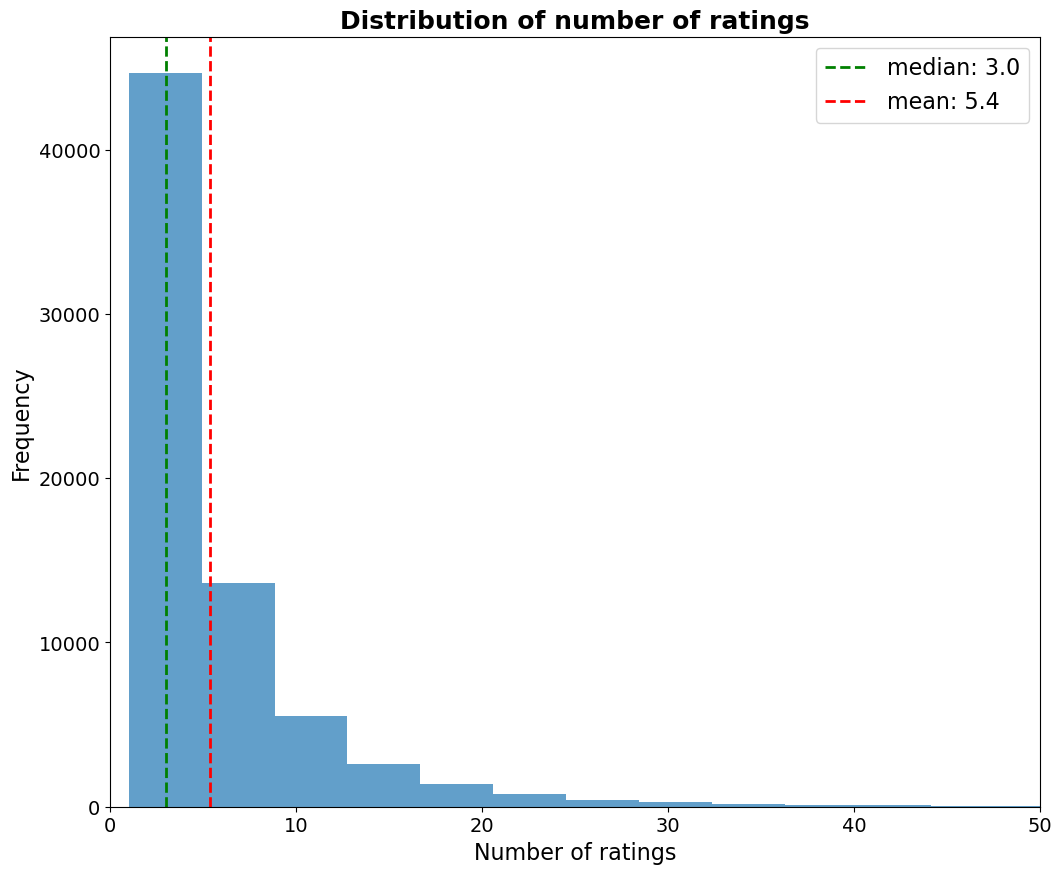

In [13]:
# plot for distribution of number of ratings 
plt.figure(figsize = (12, 10))

# histogram 
plt.hist(df["number_of_ratings"], 
         bins = 100, 
         alpha = 0.7)

# show median and mean value on the plot 
# median
plt.axvline(df["number_of_ratings"].median(), 
           color = "green", 
           linestyle = "dashed", 
           linewidth = 2, 
           label = f"median: {df['number_of_ratings'].median():.1f}")

# mean
plt.axvline(df["number_of_ratings"].mean(), 
           color = "red", 
           linestyle = "dashed", 
           linewidth = 2, 
           label= f"mean: {df['number_of_ratings'].mean():.1f}")

# aesthetics 
# title
plt.title("Distribution of number of ratings", 
          fontweight = "bold", 
          fontsize = 18)

# x axis 
plt.xlabel("Number of ratings", 
           fontsize = 16)
# limit
plt.xlim(0, 50)

# y axis
plt.ylabel("Frequency", 
           fontsize = 16)
# size for both x and y ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot
plt.show()

In [14]:
# filter out the professors with less than 5 ratings
df_filtered = df[df["number_of_ratings"] >= 5].copy()

In [15]:
# check the distribution and information about the data after filter 
df_filtered["number_of_ratings"].describe()

count    25368.000000
mean        11.150662
std         11.327791
min          5.000000
25%          6.000000
50%          8.000000
75%         12.000000
max        393.000000
Name: number_of_ratings, dtype: float64

In [16]:
# info about the dataset 
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25368 entries, 3 to 89891
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        25368 non-null  float64
 1   average_difficulty                    25368 non-null  float64
 2   number_of_ratings                     25368 non-null  float64
 3   received_a_pepper                     25368 non-null  float64
 4   would_take_again                      12160 non-null  float64
 5   number_of_ratings_online              25368 non-null  float64
 6   male_gender                           25368 non-null  int64  
 7   female_gender                         25368 non-null  int64  
 8   major                                 25368 non-null  object 
 9   university                            25368 non-null  object 
 10  state                                 25368 non-null  object 
 11  tough_grader        

The distribution of the number of ratings is highly right skewed, with a median of 3 and a mean of 5.4. Most professors receive only a small number of ratings, which leads to unstable and potentially extreme average values. To address this, we set a minimum threshold of five ratings and excluded professors with fewer than five evaluations. This cutoff is close to the mean and removes cases where average ratings are driven by very sparse data, while preserving the majority of the sample and improving the reliability of comparisons across professors. After applying this filter, 25,368 professors remain in the analysis dataset.

### Categorical variables 
In this section, we address the handling of categorical variables. Teaching style tags were normalized by dividing each tag count by the total number of tags received by a professor, converting raw counts into proportions. This normalization controls for differences in the total number of ratings and ensures that tag values are comparable across professors. Cases with no assigned tags resulted in undefined values after normalization and were set to zero, reflecting the absence of tag information rather than meaningful signal.

In addition, we examine the gender indicators provided in the dataset. The male and female variables are treated as categorical indicators.

In [17]:
# distribution of all tags before normalization 
# starting from 11th variable 
# .describe 
df_filtered.iloc[:, 11:].describe()

,tough_grader,good_feedback,respected,lots_to_read,participation_matters,dont_skip_class_or_you_will_not_pass,lots_of_homework,inspirational,pop_quizzes,accessible,so_many_papers,clear_grading,hilarious,test_heavy,graded_by_few_things,amazing_lectures,caring,extra_credit,group_projects,lecture_heavy
count,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000
mean,2.036976,2.640374,1.920451,1.548841,1.778185,1.838261,1.600047,1.216809,0.393843,0.827854,0.286187,1.505401,1.420293,0.385722,0.336447,1.423329,2.358050,1.159256,0.533783,1.094056
std,3.279020,4.120596,3.634944,2.718146,2.903643,2.988417,3.058181,2.803210,1.420362,1.794848,0.943474,2.408472,3.664116,1.241309,0.854666,3.159003,3.540912,2.935454,1.661896,1.981580
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,3.000000,3.000000,2.000000,2.000000,2.250000,2.000000,1.000000,0.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,1.000000
max,112.000000,171.000000,186.000000,82.000000,82.000000,110.000000,141.000000,119.000000,97.000000,63.000000,64.000000,77.000000,224.000000,81.000000,39.000000,136.000000,127.000000,128.000000,92.000000,38.000000


In [18]:
# calculate total # of tags for each professor
total_tag_counts = df_filtered[df_tags_column_names].sum(axis = 1)

# normalize tag columns to be between 0 and 1 by dividing tag counts by total tag counts
for col in df_tags_column_names:
    df_filtered[col] = df_filtered[col] / total_tag_counts

# fill na values with 0 that resulted from divide by zero issues
df_filtered[df_tags_column_names] = df_filtered[df_tags_column_names].fillna(0)

In [19]:
# look at the distribution of tags after the normalization 
df_filtered.iloc[:, 11:].describe()

,tough_grader,good_feedback,respected,lots_to_read,participation_matters,dont_skip_class_or_you_will_not_pass,lots_of_homework,inspirational,pop_quizzes,accessible,so_many_papers,clear_grading,hilarious,test_heavy,graded_by_few_things,amazing_lectures,caring,extra_credit,group_projects,lecture_heavy
count,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000,25368.000000
mean,0.085069,0.100868,0.068629,0.062054,0.069651,0.069879,0.064489,0.041886,0.015234,0.028761,0.012109,0.058709,0.049038,0.013922,0.014433,0.047059,0.088719,0.041532,0.021918,0.045526
std,0.107520,0.091155,0.074261,0.084513,0.078161,0.078915,0.086387,0.061327,0.044127,0.045961,0.034345,0.067916,0.075274,0.035435,0.035939,0.064779,0.082976,0.068912,0.052664,0.071531
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.047619,0.083333,0.055556,0.025000,0.052632,0.052632,0.029168,0.000000,0.000000,0.000000,0.000000,0.044776,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,0.000000,0.000000
75%,0.136364,0.153846,0.111111,0.100000,0.111111,0.111111,0.100000,0.068966,0.000000,0.050000,0.000000,0.090909,0.076923,0.000000,0.000000,0.076923,0.142857,0.065217,0.000000,0.071429
max,1.000000,1.000000,0.600000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000,0.666667,0.500000,0.666667,0.625000,1.000000,0.500000,0.666667,1.000000,0.862069,0.545455,1.000000


Now, we are looking at gender variables. 

In [20]:
# check male and female gender error, where both are 1, or both 0
both_11 = df_filtered[(df_filtered["male_gender"] == 1) & (df_filtered["female_gender"] == 1)].shape[0]
both_00 = df_filtered[(df_filtered["male_gender"] == 0) & (df_filtered["female_gender"] == 0)].shape[0]

# print the results 
print(f"Number of professors with both male and female gender as 1: {both_11}")
print(f"Number of professors with both male and female gender as 0: {both_00}")

Number of professors with both male and female gender as 1: 776
Number of professors with both male and female gender as 0: 6170


This is a clear data error and should be removed. 

In [21]:
# drop rows where both male and female gender are 1 or 0
df_filtered_final = df_filtered[~((df_filtered["male_gender"] == 1) & (df_filtered["female_gender"] == 1)) & 
                          (~((df_filtered["male_gender"] == 0) & (df_filtered["female_gender"] == 0)))].copy()

# check the results
df_filtered_final.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        18422 non-null  float64
 1   average_difficulty                    18422 non-null  float64
 2   number_of_ratings                     18422 non-null  float64
 3   received_a_pepper                     18422 non-null  float64
 4   would_take_again                      8849 non-null   float64
 5   number_of_ratings_online              18422 non-null  float64
 6   male_gender                           18422 non-null  int64  
 7   female_gender                         18422 non-null  int64  
 8   major                                 18422 non-null  object 
 9   university                            18422 non-null  object 
 10  state                                 18422 non-null  object 
 11  tough_grader        

After data pre-processing, we are left with ~18k rows. Now we will proceed answering research questions. 

## Q1. Activists have asserted that there is a strong gender bias in student evaluations of professors, with male professors enjoying a boost in rating from this bias...We would like you to answer the question whether there is evidence of a pro-male gender bias in this dataset.


In [22]:
# separate the average ratings into two groups based on gender
# Male = 1, Male = 0
df1_male = df_filtered_final[df_filtered_final["male_gender"] == 1]
df1_female = df_filtered_final[df_filtered_final["male_gender"] == 0]

In [23]:
# count number of professors in each group
print(f"Number of male professors: {df1_male.shape[0]}")
print(f"Number of female professors: {df1_female.shape[0]}")

Number of male professors: 10015
Number of female professors: 8407


A difference is noticeable, but not very large. We can proceed with the analysis. 

C:\Users\nyuss\AppData\Local\Temp\ipykernel_16896\2381853625.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered_final,


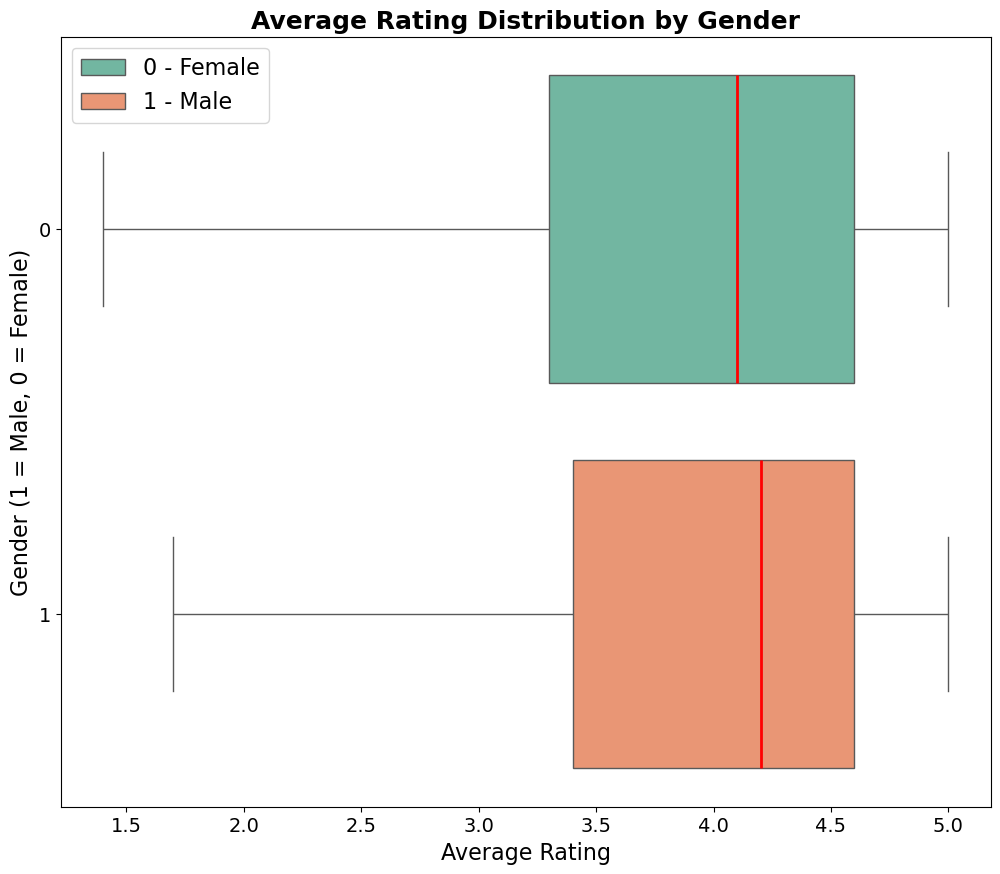

In [24]:
# compare distributions of average rating between male and female professors
plt.figure(figsize=(12, 10))

# box plot for male and female professors 
sns.boxplot(data=df_filtered_final, 
            x='average_rating', 
            y='male_gender', 
            palette = "Set2", 
            showfliers = False, 
            medianprops = {"color": "red", "linewidth": 2}, 
            orient= "horizontal")

# aesthetics 
plt.title('Average Rating Distribution by Gender', 
          fontweight = "bold",
          fontsize = 18)

# xlabel
plt.xlabel('Average Rating', 
           fontsize = 16)
# ylabel
plt.ylabel('Gender (1 = Male, 0 = Female)', 
           fontsize = 16)

# legend
plt.legend(['0 - Female', 
            '1 - Male'], 
            fontsize = 16,
           loc = "upper left")
# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

plt.show()

The boxplot suggests a small difference in average ratings by gender. The distributions for male and female professors overlap substantially, but the male distribution appears slightly shifted to the right, with a higher median average rating. The spread of ratings is similar across genders, indicating comparable variability. To further test the difference, we have to apply a significance test. 

Using average ratings separated by gender, we test whether male professors receive higher average ratings than female professors. 

We use a one-tailed Mann-Whitney U test to compare average ratings by gender. This test is appropriate because average ratings are ordinal and non-normal. 

`Null hypothesis (H0):` Average ratings for male professors are not different than average ratings of female professors.

`Alternative hypothesis (Ha):` Average ratings for male professors are significantly higher than those for female professors.

`Significance level:` 0.005

If the p-value is smaller than 0.005, it means such a result would be very unlikely by chance under the null hypothesis, so we reject the H0 and conclude that average ratings for male professors are significantly higher than those for female professors. 

If the p-value is larger than 0.005, then the observed difference could easily occur by random variation, so we fail to reject the H0, meaning data does not provide enough statistical evidence to conclude that average ratings differ. 

In [25]:
# conduct mann-whitney u test for average rating using our function
u_stat, p_value = stats.mannwhitneyu(df1_male['average_rating'], 
                                     df1_female['average_rating'], 
                                     alternative='greater')
# interpretation 
significance(0.005, p_value)


p-value: 0.00024523
p = 0.00024523 < α = 0.005 = Reject H0 (statistically significant).


Our p-value (0.00024523) is smaller than 0.005, so we reject the Null Hypothesis and conclude that average ratings for male professors are significantly higher than for female professors. It does not mean that we found an evidence of pro-male ratings bias, as our data is not randomized and we are not controlling for all confounders. However we found a statistical evidence that average ratings of male professors are higher. 

## Q2. Is there a gender difference in the spread (variance/dispersion) of the ratings distribution? Again, it is advisable to consider the statistical significance of any observed gender differences in this sprea

In [26]:
# again_separate the average ratings into two groups based on gender
# Male = 1, Male = 0
df2_male = df_filtered_final[df_filtered_final["male_gender"] == 1]
df2_female = df_filtered_final[df_filtered_final["male_gender"] == 0]

In [27]:
# count number of professors in each group
print(f"Number of male professors: {df2_male.shape[0]}")
print(f"Number of female professors: {df2_female.shape[0]}")


Number of male professors: 10015
Number of female professors: 8407


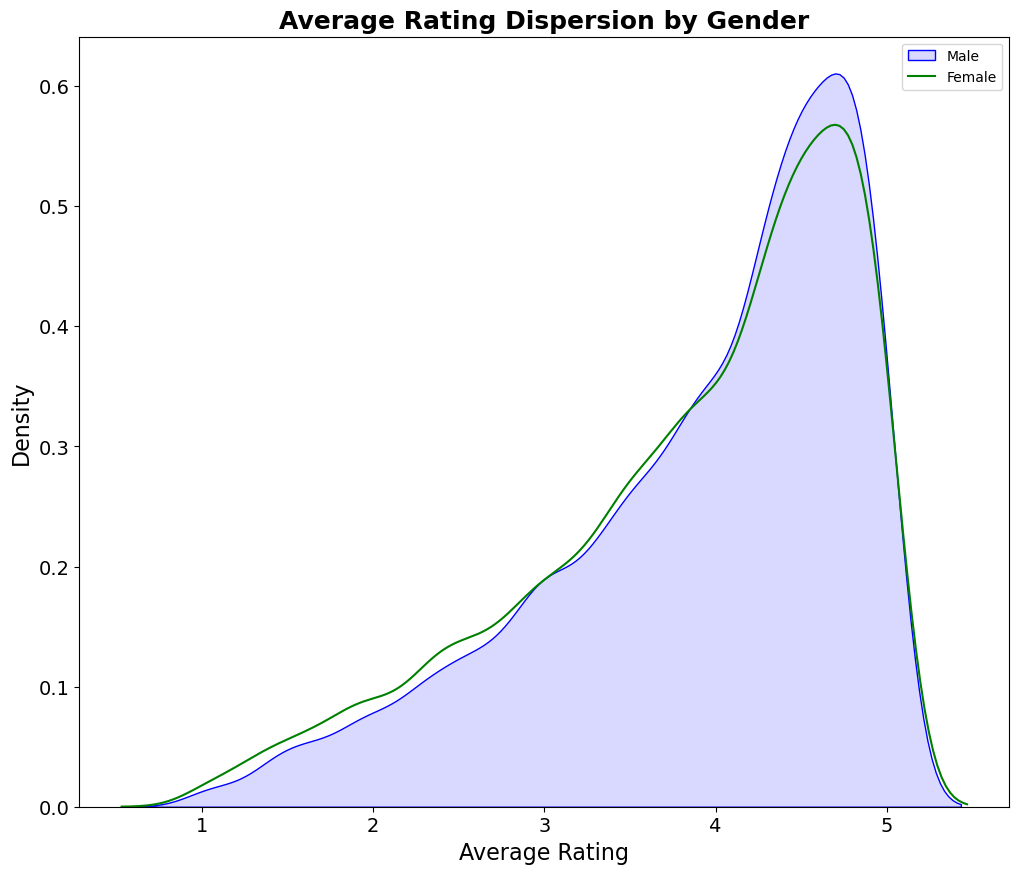

In [28]:
# plot the variance of average rating dipersion between male and female professors
# kernel density plot 
plt.figure(figsize=(12, 10))

# plot
sns.kdeplot(df2_male['average_rating'], 
           label='Male', 
           color='blue', 
           fill=True, 
           legend= True, 
           alpha=0.15
           )
sns.kdeplot(df2_female['average_rating'],
              label='Female', 
              color='green', 
              fill=False, 
              legend= True)

# aesthetics
plt.title('Average Rating Dispersion by Gender', 
          fontweight = "bold",
          fontsize = 18)
# xlabel
plt.xlabel('Average Rating',
              fontsize = 16)
# ylabel
plt.ylabel('Density',
                fontsize = 16)

# axis 
plt.tick_params(axis = "both", 
                labelsize = 14)
# legend 
plt.legend()
# ticks
plt.show()

The density curves for average ratings by gender are highly similar, indicating comparable dispersion across male and female professors. Both distributions span a similar range and show similar tail behavior, which suggests no large difference in variability. The male distribution is slightly shifted to the right, consistent with higher average ratings, but the overall spread and shape of the two distributions closely align. Viisually we can not observe any significant and/or major differences in variance. 

In order to test the dispersion of average ratings by gender, we use two-tailed Levene's test with a median function. Levene's test is appropriate for average ratings, since it is robust to normality violations, and able to utilize both median and mean metrics for comparison. 

`Null hypothesis (H0):` Average ratings dispersion of male professors is not different from female professors’ average ratings dispersion.   

`Alternative hypothesis (Ha):` Average ratings dispersion of male professors is significantly different than average ratings dispersion of female professors. 

`Significance level:` 0.005

If the p-value is smaller than 0.005, it means such a result would be very unlikely by chance under the null hypothesis, so we reject the H0 and conclude that there is a significant difference in dispersion of average ratings by 2 gender groups. 

If the p-value is larger than 0.005, then the observed difference could easily occur by random variation, so we fail to reject the H0, meaning data does not provide enough statistical evidence to conclude that there is a significant dispersion difference. 


In [29]:
# dispersion of average ratings 
# levene's test for equal variances
levene_stat, levene_p_value = stats.levene(df2_male['average_rating'], 
                                      df2_female['average_rating'], 
                                      center='median')

# check the result 
significance(0.005, levene_p_value)

p-value: 5.97717e-06
p = 5.97717e-06 < α = 0.005 = Reject H0 (statistically significant).


Our p-value (5.97717e-06) is significantly smaller than 0.005, which means that our observed data is unlikely to appear by chance and there is a significant difference in dispersion of male and female professors' average ratings. 

## Q3. What is the likely size of both of these effects (gender bias in average rating, gender bias in spread of average rating), as estimated from this dataset? Please use 95% confidence and make sure to report each/both. 

Because our ratings are ordinal and non-normal, we do not use parametric effect sizes like Cohen's D or hedges G, as these assume normality and equal variance of the data.

To compute effect size for our average difficulty ratings of professors, we had to find a non-parametric alternative of Cohen's d that will be as interpretable and practical.

We found a peer-reviewed scientific paper published by [`Kane Meissel and Esther S. Yao`](https://github.com/NBeibarys/Project-Hypothesis-Testing-of-MovieRatings-Using-Python/blob/main/project_guidelines/Using%20Cliff%E2%80%99s%20Delta%20as%20a%20Non-Parametric%20Effect%20Size%20Measure.pdf) from University of Aucklannd in 2024, which proposes a non-parametric measure of effect size suitable for ordinal data.

`Cliff's Delta (δ) Interpretation`:

Always compare the magnitudes in a reference to a group that is tested, not values of (δ):
- |δ| < 0.15 (less than 15% non-overlap between groups 1 and 2) = negligible effect
- 0.15 <= |δ| < 0.33 = small effect
- 0.33 <= |δ| < 0.47 = medium effect
- |δ| >= 0.47 = large effect

In [39]:
 # divide average ratings by groups of gender and convert to arrays (bootstrap expects that)
df3_male = df_filtered_final[df_filtered_final["male_gender"] == 1]
df3_female = df_filtered_final[df_filtered_final["male_gender"] == 0]

# define function for effect size 
def cliffs_delta_trap(sample1, sample2, axis = 0):
    return cd(sample1, sample2)[0]

# Perform the bootstrap
result = stats.bootstrap(
    (df3_male['average_rating'].to_numpy(), 
    df3_female['average_rating'].to_numpy()), 
    statistic=cliffs_delta_trap,
    confidence_level=0.95, 
    random_state= n_number, 
    vectorized= False,
    method='BCa', 
    n_resamples=10000)

# compute the confidence interval
ci_lower, ci_upper = result.confidence_interval.low, result.confidence_interval.high

# print the results 
# point estimate
print(f"Effect size (Cliffs delta): {cd(df3_male['average_rating'], 
                                        df3_female['average_rating'])[0]:.4f}")

# confidence interval
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")




Effect size (Cliffs delta): 0.0297
95% CI: [0.0127, 0.0466]


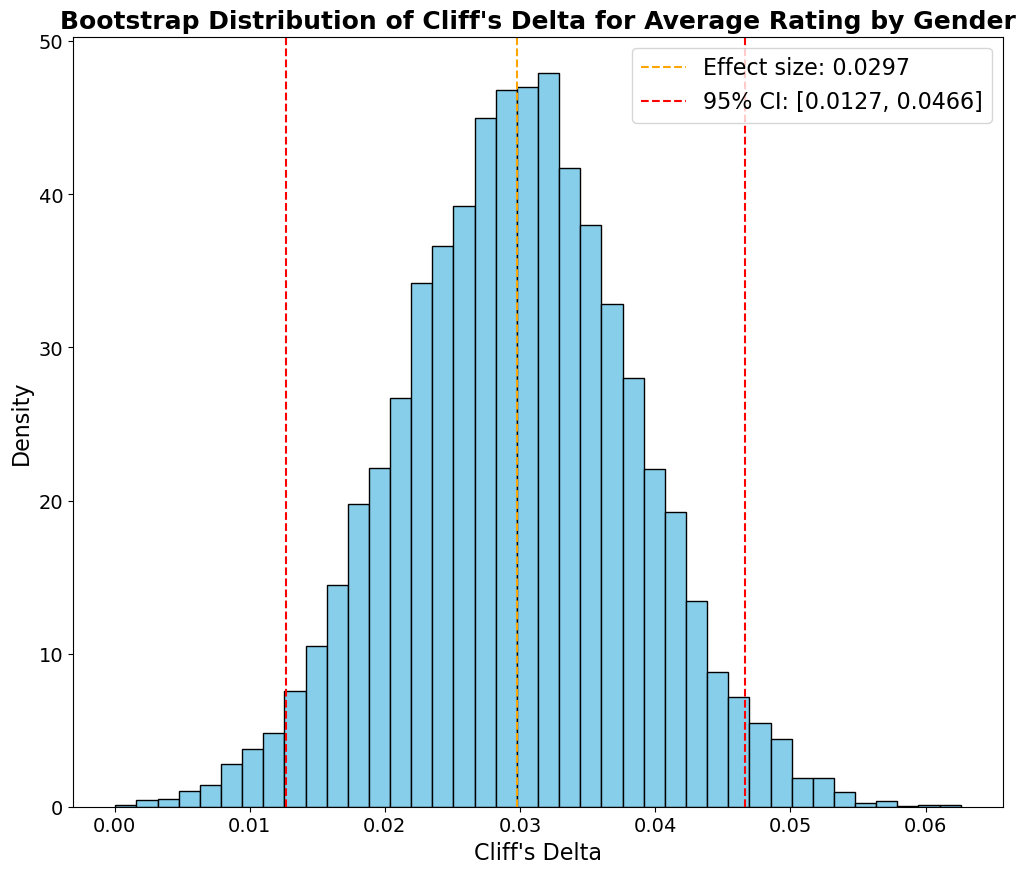

In [40]:
# plot boostrap distribution of cliffs delta
# figure size 
plt.figure(figsize=(12, 10))

# plot
plt.hist(result.bootstrap_distribution, 
         bins=40, 
         density=True, 
         color = "skyblue",
         edgecolor = "black",
         fill = True)

# point estimate line
plt.axvline(cd(df3_male['average_rating'].to_numpy(), 
                df3_female['average_rating'].to_numpy())[0], 
            color = "orange", 
            linestyle = "dashed", 
            label = f"Effect size: {cd(df3_male['average_rating'].to_numpy(), 
                                            df3_female['average_rating'].to_numpy())[0]:.4f}"
            )

# confidence interval lines
# lower
plt.axvline(ci_lower, 
            color = "red", 
            linestyle = "dashed", 
            label = f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]"
            )
# upper
plt.axvline(ci_upper, 
            color = "red", 
            linestyle = "dashed")

# aesthetics
# title 
plt.title("Bootstrap Distribution of Cliff's Delta for Average Rating by Gender", 
          fontweight = "bold",
          fontsize = 18)

# x and y axis labels
plt.xlabel("Cliff's Delta", 
           fontsize = 16)
plt.ylabel("Density", 
           fontsize = 16)

# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot 
plt.show()
         

A 95 percent confidence interval means that, over repeated samples, 95 percent of such intervals would contain the true Cliff’s delta. In this case, the estimated Cliff’s delta lies between 0.0127 and 0.0466, with a point estimate of 0.0297. This corresponds to a negligible effect size, meaning that the distributions of average ratings for male and female professors are almost entirely overlapping. Although this difference is statistically detectable given the large sample size, it does not represent a practically meaningful difference in central tendency and provides little evidence of substantive gender bias in average ratings.

Now we will compute a point estimate and 95% confidence interval for dispersion difference effect size. To measure the effect size of dispersion, we substract the female variance from male variance. 

In [42]:
# variance difference in average rating for male and female professors
def variance_diff(sample1, sample2, axis = 0):
    # compute variance for each sample
    variance1 = np.var(sample1, ddof = 1)
    variance2 = np.var(sample2, ddof = 1)
    return variance1 - variance2   # male minus female

# compute the bootstrap
result_variance = stats.bootstrap(
    data=(df3_male['average_rating'].to_numpy(), 
    df3_female['average_rating'].to_numpy()),
    statistic=variance_diff,
    confidence_level=0.95,
    n_resamples=10000,
    method='BCa',
    random_state=n_number,
    vectorized=False
)

# compute the confidence interval
ci_lower_variance, ci_upper_variance = result_variance.confidence_interval.low, result_variance.confidence_interval.high

# print the results 
# point estimate
print(f"Effect size (variance difference): {variance_diff(df3_male['average_rating'], df3_female['average_rating'])}")
# confidence interval
print(f"95% CI: [{ci_lower_variance:.4f}, {ci_upper_variance:.4f}]")



Effect size (variance difference): -0.07755275266973649
95% CI: [-0.1128, -0.0411]


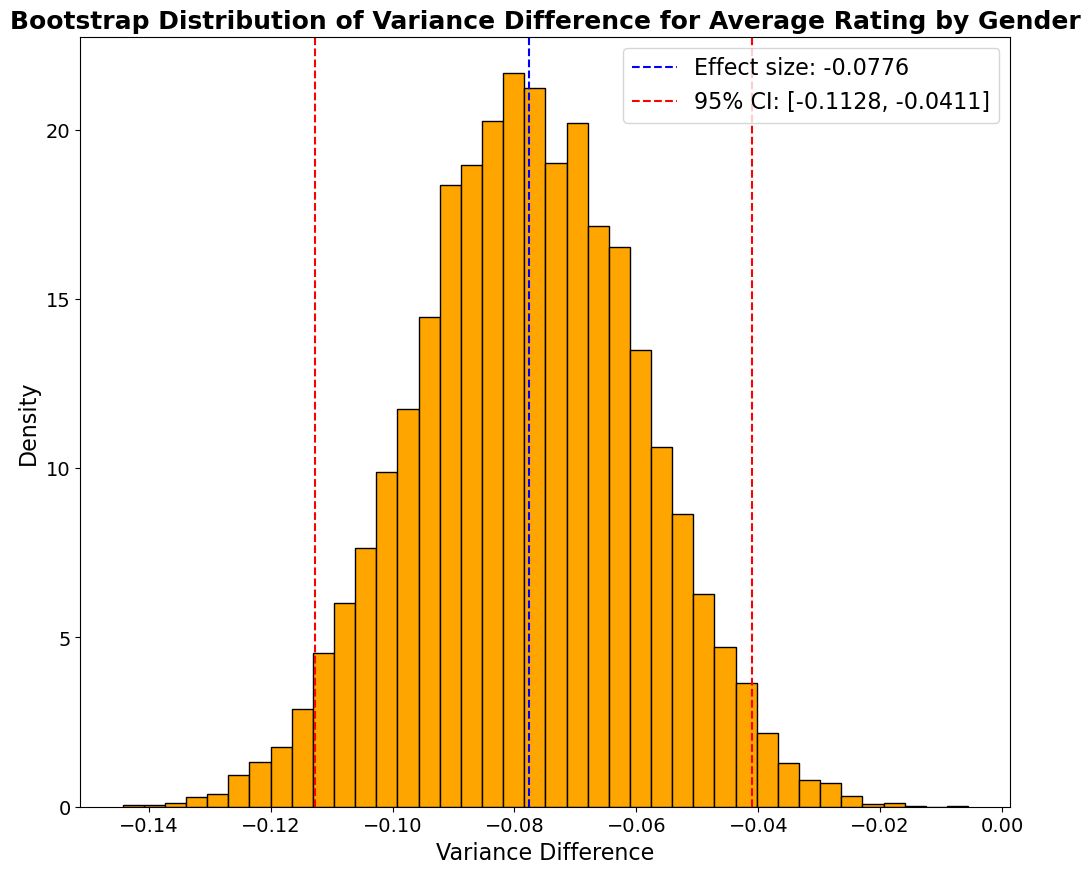

In [46]:
# plot boostrap distribution of variance difference
# figure size 
plt.figure(figsize=(12, 10))

# plot
plt.hist(result_variance.bootstrap_distribution, 
         bins=40, 
         density=True, 
         color = "orange",
         edgecolor = "black",
         fill = True)

# point estimate line
plt.axvline(variance_diff(df3_male['average_rating'], 
                df3_female['average_rating']), 
            color = "blue", 
            linestyle = "dashed", 
            label = f"Effect size: {variance_diff(df3_male['average_rating'], df3_female['average_rating']):.4f}"
            )

# confidence interval lines
# lower
plt.axvline(ci_lower_variance, 
            color = "red", 
            linestyle = "dashed", 
            label = f"95% CI: [{ci_lower_variance:.4f}, {ci_upper_variance:.4f}]"
            )
# upper
plt.axvline(ci_upper_variance, 
            color = "red", 
            linestyle = "dashed")

# aesthetics
# title 
plt.title("Bootstrap Distribution of Variance Difference for Average Rating by Gender", 
          fontweight = "bold",
          fontsize = 18)

# x and y axis labels
plt.xlabel("Variance Difference", 
           fontsize = 16)
plt.ylabel("Density", 
           fontsize = 16)

# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot 
plt.show()

# show the plot 
plt.show()
         


A 95 percent bootstrap confidence interval means that, across repeated resampling, 95 percent of such intervals would contain the true variance difference. The estimated variance difference in average ratings between male and female professors is −0.0776, with a 95 percent CI from −0.1128 to −0.0411. The interval lies entirely below zero, indicating that average ratings for female professors exhibit slightly greater dispersion than those for male professors. However, the magnitude of this difference is very small in absolute terms. This suggests that, although the difference in spread is statistically detectable due to the large sample size, it is negligible in practice and provides little evidence of meaningful gender bias in rating variability.

#

## Q4.  Is there a gender difference in the tags awarded by students? Make sure to test each of the 20 tags for a potential gender difference and report which of them exhibit a statistically significant difference. Comment on the 3 most gendered (lowest p-value) and least gendered (highest p-value) tags for a potential gender difference and report which of them exhibit a statistically significant difference. Comment on the 3 most gendered (lowest p-value) and least gendered (highest p-value) tags.

Since we converted each tag variable as proportion of all tags awarded to a professor, our tag proportions are skewed. It means that we cannot assume normality and equal variance. That is why non-parametric two-tailed Mann-Whitney U test was used to test a gender difference in the tags awarded by students. 

`Null hypothesis (H0):` The distribution of tag proportions is the same for male and female professors.

`Alternative hypothesis (Ha):` The distribution of tag proportions significantly differs between male and female professors.

`Significance level:` 0.005

If the p-value is smaller than 0.005, it means such a result would be very unlikely by chance under the null hypothesis, so we reject the H0 and conclude that tag proportions differ by gender. 

If the p-value is larger than 0.005, then the observed difference could easily occur by random variation, so we fail to reject the H0, meaning data does not provide enough statistical evidence to conclude that there is significant difference in tag proportions by gender. 

We computed Mann-Whitney U test for each tag in the dataset.

In [68]:
# filter our the data for this question 
df4_male = df_filtered_final[df_filtered_final["male_gender"] == 1]
df4_female = df_filtered_final[df_filtered_final["male_gender"] == 0]

# filter mask for all tags columns
tag_columns = df_tags_column_names
alpha = 0.005

# list for all tags 
results_q4 = []

# for loop for separating each movie subset into two groups and conducting the non-parametric test
for tag in tag_columns: 
    # separating into two groups
    males = df4_male[tag]
    females = df4_female[tag]

    # conducting the test 
    u_statistic, p_value = stats.mannwhitneyu(males, females, alternative= 'two-sided')
    
    # save data as well
    results_q4.append({
    "tag": tag,
    "n_female": len(females),
    "n_male": len(males),
    "U": u_statistic,
    "p_value": p_value,
    "significant": p_value < alpha
    })
        
    # # use the significance function created 
    # print(f"{tag} Result:")
    # print(f"{significance(0.005, p_value)}\n")

# check the results
results_q4_df = pd.DataFrame(results_q4).sort_values(by = 'p_value', ascending= False)
styled = results_q4_df.style.set_properties(**{
    "background-color": "white",
    "color": "black", 
     "border": "1px solid black"
}).format({"p_value": "{:.6e}"})

# sort by p-value
styled

,tag,n_female,n_male,U,p_value,significant
8,pop_quizzes,8407,10015,42356129.000000,2.698978e-01,False
9,accessible,8407,10015,42929904.500000,9.133809e-03,False
0,tough_grader,8407,10015,41056014.500000,2.637471e-03,True
11,clear_grading,8407,10015,40888751.000000,5.379880e-04,True
7,inspirational,8407,10015,43455897.500000,4.188542e-05,True
5,dont_skip_class_or_you_will_not_pass,8407,10015,40573252.500000,1.282860e-05,True
13,test_heavy,8407,10015,43444751.000000,8.194516e-08,True
3,lots_to_read,8407,10015,40243731.000000,5.192685e-08,True
6,lots_of_homework,8407,10015,40193393.000000,1.974495e-08,True
10,so_many_papers,8407,10015,40325013.000000,1.719188e-13,True


We tested all 20 tag proportions for gender differences using two tailed Mann-Whitney U tests at a significance level of 0.005. Most tags show statistically detectable gender differences, while a small number do not. The least gendered tags are pop_quizzes and accessible, which have the highest p values and show no evidence of a gender difference, and tough_grader, which shows only weak evidence. The most gendered tags are hilarious, amazing_lectures, and a participation_matters, which have the lowest p values and the strongest statistical evidence of a difference in tag proportions by gender. 

## Q5. Is there a gender difference in terms of average difficulty? Again, a significance test is indicated.

In [69]:
# separate into two groups based on gender
# Male = 1, Male = 0
df5_male = df_filtered_final[df_filtered_final["male_gender"] == 1]
df5_female = df_filtered_final[df_filtered_final["male_gender"] == 0]

In [70]:
# check quantity 
# it is the same number of rows, so this code is just in case
print(f"Number of male professors: {df5_male.shape[0]}")
print(f"Number of female professors: {df5_female.shape[0]}")

Number of male professors: 10015
Number of female professors: 8407


C:\Users\nyuss\AppData\Local\Temp\ipykernel_16896\2358968866.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered_final,


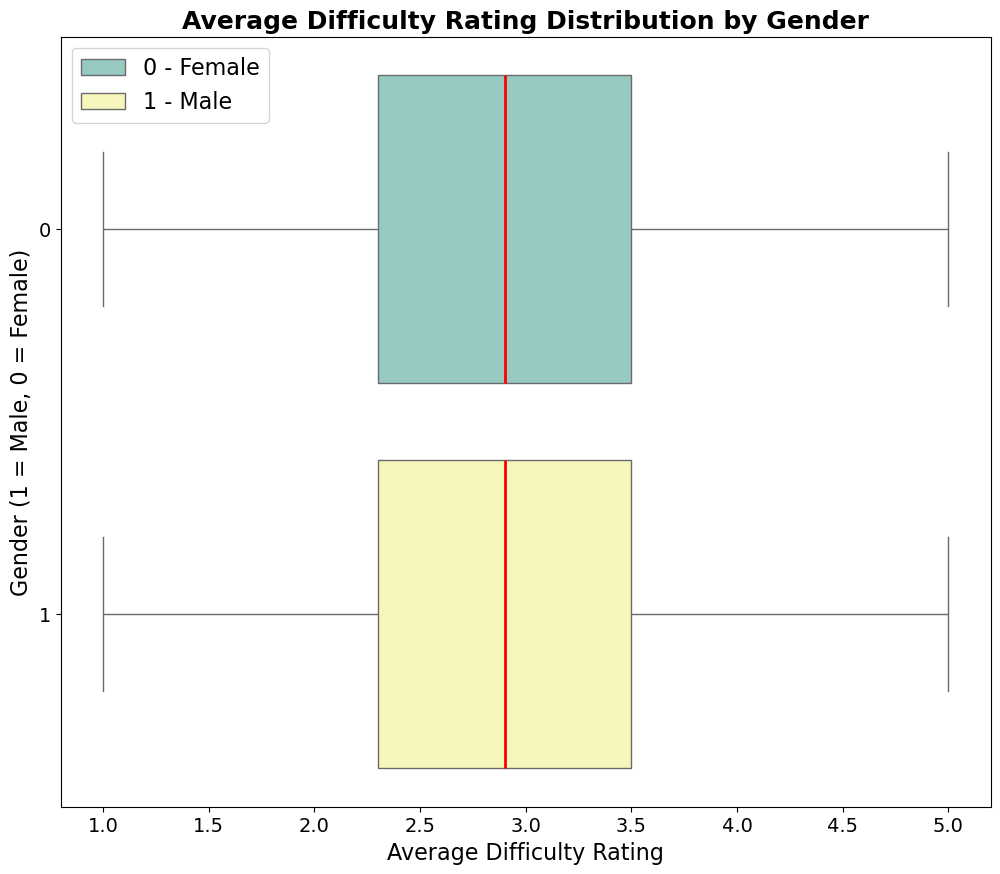

In [72]:
# compare distributions of average rating between male and female professors
plt.figure(figsize=(12, 10))

# box plot for male and female professors 
sns.boxplot(data=df_filtered_final, 
            x='average_difficulty', 
            y='male_gender', 
            palette = "Set3", 
            showfliers = False, 
            medianprops = {"color": "red", "linewidth": 2}, 
            orient= "horizontal")

# aesthetics 
plt.title('Average Difficulty Rating Distribution by Gender', 
          fontweight = "bold",
          fontsize = 18)

# xlabel
plt.xlabel('Average Difficulty Rating', 
           fontsize = 16)
# ylabel
plt.ylabel('Gender (1 = Male, 0 = Female)', 
           fontsize = 16)

# legend
plt.legend(['0 - Female', 
            '1 - Male'], 
            fontsize = 16,
           loc = "upper left")
# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

plt.show()

Box plot of average difficulty ratings does not reveal any significant differences between male and female professors. At least visually, there is no significance. To test the statistical significance test, we apply the Mann-Whitney U test.

 We use a two-tailed Mann-Whitney U test to compare average difficulty ratings by gender. This test is appropriate because average ratings are ordinal and non-normal. 

`Null hypothesis (H0):` Average difficulty ratings for male professors are not different than average difficulty ratings of female professors.

`Alternative hypothesis (Ha):` Average difficulty ratings for male professors are significantly different from average difficulty ratings of female professors. 

`Significance level:` 0.005

If the p-value is smaller than 0.005, it means such a result would be very unlikely by chance under the null hypothesis, so we reject the H0 and conclude that average difficulty ratings for male professors are significantly different from average difficulty ratings of female professors. 

If the p-value is larger than 0.005, then the observed difference could easily occur by random variation, so we fail to reject the H0, meaning data does not provide enough statistical evidence to conclude that there is a significant difference in average difficulty ratings by gender. 

In [75]:
# conduct mann-whitney u test for average rating using our function
u_stat, p_value = stats.mannwhitneyu(df1_male['average_difficulty'], 
                                     df1_female['average_difficulty'], 
                                     alternative='two-sided')
# interpretation 
significance(0.005, p_value)

p-value: 0.828753
p = 0.828753 ≥ α = 0.005 = Fail to reject H0 (not statistically significant).


The Mann-Whitney U test yielded a p-value of approximately 0.823, which is much larger than the significance level. Therefore, we fail to reject the null hypothesis. This indicates that the observed differences in average difficulty ratings are consistent with random variation, and the data provide no statistical evidence of a gender difference in perceived course difficulty

## 6. Please quantify the likely size of this effect at 95% confidence

Because our average difficulry ratings are also ordinal and non-normal, we do not use parametric effect sizes like Cohen's D or hedges G, as these assume normality and equal variance of the data.

To compute effect size for our average difficulty ratings of profesors, we had to find a non-parametric alternative of Cohen's d that will be as interpretable and practical.

We found a peer-reviewed scientific paper published by [`Kane Meissel and Esther S. Yao`](https://github.com/NBeibarys/Project-Hypothesis-Testing-of-MovieRatings-Using-Python/blob/main/project_guidelines/Using%20Cliff%E2%80%99s%20Delta%20as%20a%20Non-Parametric%20Effect%20Size%20Measure.pdf) from University of Aucklannd in 2024, which proposes a non-parametric measure of effect size suitable for ordinal data.

`Cliff's Delta (δ) Interpretation`:

Always compare the magnitudes in a reference to a group that is tested, not values of (δ):
- |δ| < 0.15 (less than 15% non-overlap between groups 1 and 2) = negligible effect
- 0.15 <= |δ| < 0.33 = small effect
- 0.33 <= |δ| < 0.47 = medium effect
- |δ| >= 0.47 = large effect

In [83]:
 # divide average difficulty ratings by groups of gender and convert to arrays (bootstrap expects that)
df6_male = df_filtered_final[df_filtered_final["male_gender"] == 1]
df6_female = df_filtered_final[df_filtered_final["male_gender"] == 0]

# define function for effect size 
def cliffs_delta_trap(sample1, sample2, axis = 0):
    return cd(sample1, sample2)[0]

# Perform the bootstrap
result_q6 = stats.bootstrap(
    (df6_male['average_difficulty'].to_numpy(), 
    df6_female['average_difficulty'].to_numpy()), 
    statistic=cliffs_delta_trap,
    confidence_level=0.95, 
    random_state= n_number, 
    vectorized= False,
    method='BCa', 
    n_resamples=10000)

# compute the confidence interval
ci_lower_q6, ci_upper_q6 = result_q6.confidence_interval.low, result_q6.confidence_interval.high

# print the results 
# point estimate
print(f"Effect size (Cliffs delta): {cd(df6_male['average_difficulty'], 
                                        df6_female['average_difficulty'])[0]:.4f}")

# confidence interval
print(f"95% CI: [{ci_lower_q6:.4f}, {ci_upper_q6:.4f}]")


Effect size (Cliffs delta): 0.0018
95% CI: [-0.0152, 0.0182]


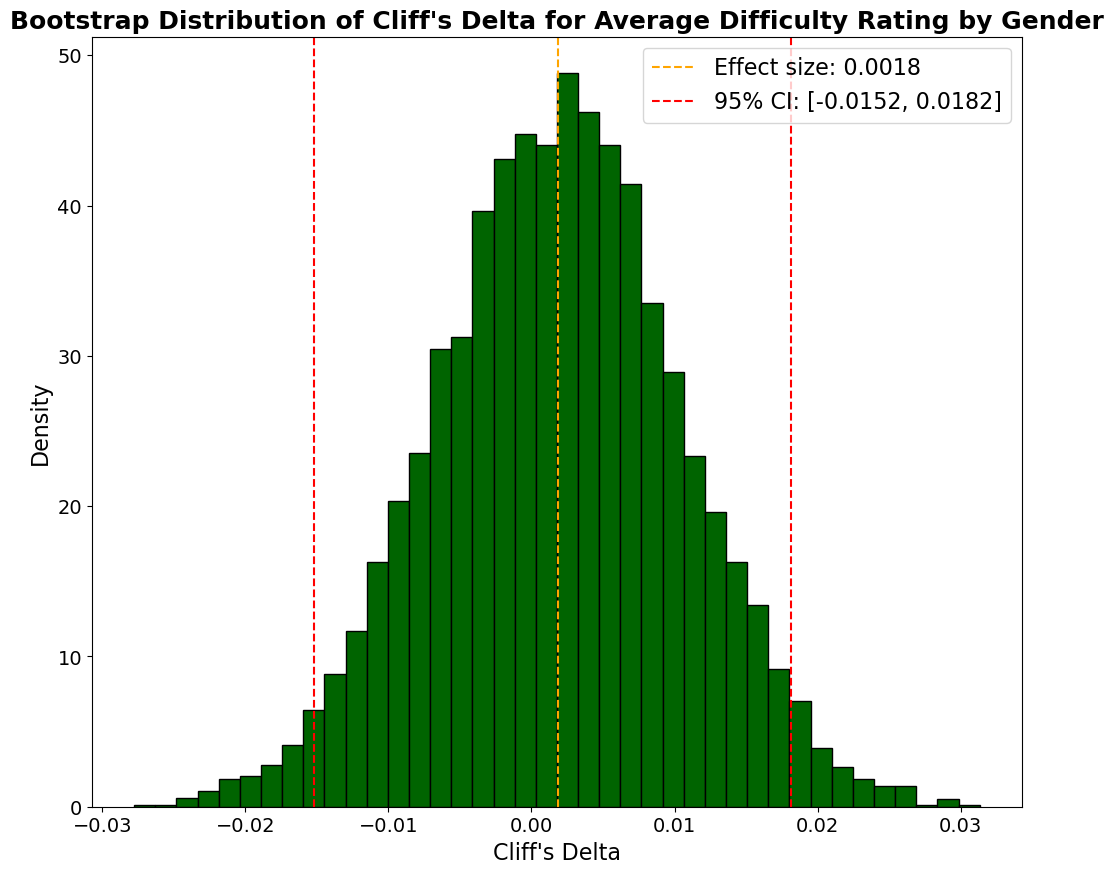

In [85]:
# plot boostrap distribution of cliffs delta
# figure size 
plt.figure(figsize=(12, 10))

# plot
plt.hist(result_q6.bootstrap_distribution, 
         bins=40, 
         density=True, 
         color = "darkgreen",
         edgecolor = "black",
         fill = True)

# point estimate line
plt.axvline(cd(df6_male['average_difficulty'].to_numpy(), 
                df6_female['average_difficulty'].to_numpy())[0], 
            color = "orange", 
            linestyle = "dashed", 
            label = f"Effect size: {cd(df6_male['average_difficulty'].to_numpy(), 
                                            df6_female['average_difficulty'].to_numpy())[0]:.4f}"
            )

# confidence interval lines
# lower
plt.axvline(ci_lower_q6, 
            color = "red", 
            linestyle = "dashed", 
            label = f"95% CI: [{ci_lower_q6:.4f}, {ci_upper_q6:.4f}]"
            )
# upper
plt.axvline(ci_upper_q6, 
            color = "red", 
            linestyle = "dashed")

# aesthetics
# title 
plt.title("Bootstrap Distribution of Cliff's Delta for Average Difficulty Rating by Gender", 
          fontweight = "bold",
          fontsize = 18)

# x and y axis labels
plt.xlabel("Cliff's Delta", 
           fontsize = 16)
plt.ylabel("Density", 
           fontsize = 16)

# ticks 
plt.tick_params(axis = "both", 
                labelsize = 14)

# legend 
plt.legend(fontsize = 16)

# show the plot 
plt.show()

After computing 95% Confidence Interval using Boostrap sampling, the estimated Cliff's delta lies between −0.0152 and 0.0182, with a point estimate of 0.0018. This corresponds to a negligible effect size, indicating that the distributions of average difficulty ratings for male and female professors are almost entirely overlapping. The interval includes zero, providing no practical evidence of a meaningful gender difference in perceived course difficulty.

## 9. Build a regression model predicting average difficulty from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R2 and RMSE of this model. Which of these tags is most strongly predictive of average difficulty? 

In [180]:
# first, make a subset of all variables that are needed. 
df_9 = df_filtered_final[["average_difficulty"] + df_tags_column_names].copy()

# check 
df_9.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_difficulty                    18422 non-null  float64
 1   tough_grader                          18422 non-null  float64
 2   good_feedback                         18422 non-null  float64
 3   respected                             18422 non-null  float64
 4   lots_to_read                          18422 non-null  float64
 5   participation_matters                 18422 non-null  float64
 6   dont_skip_class_or_you_will_not_pass  18422 non-null  float64
 7   lots_of_homework                      18422 non-null  float64
 8   inspirational                         18422 non-null  float64
 9   pop_quizzes                           18422 non-null  float64
 10  accessible                            18422 non-null  float64
 11  so_many_papers      

In [181]:
# separate y (dependent variable) and x(independent variables)
y = df_9["average_difficulty"]
x = df_9.drop(columns = "average_difficulty")

# check 
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tough_grader                          18422 non-null  float64
 1   good_feedback                         18422 non-null  float64
 2   respected                             18422 non-null  float64
 3   lots_to_read                          18422 non-null  float64
 4   participation_matters                 18422 non-null  float64
 5   dont_skip_class_or_you_will_not_pass  18422 non-null  float64
 6   lots_of_homework                      18422 non-null  float64
 7   inspirational                         18422 non-null  float64
 8   pop_quizzes                           18422 non-null  float64
 9   accessible                            18422 non-null  float64
 10  so_many_papers                        18422 non-null  float64
 11  clear_grading       

In [182]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=n_number)

# check distributions of the data 
print(f'Number of rows for train data:{y_train.shape[0]}\n')
print(f'Number of rows for test data:{y_test.shape[0]}\n')

Number of rows for train data:14737

Number of rows for test data:3685



Quite good amount of rows both in training and test data, we can proceed with the analysis. 

In [183]:
# correlations between y and x predictors 
corr_yx = df_9.corr()["average_difficulty"].drop("average_difficulty")

corr_yx.sort_values(ascending=False)

tough_grader                            0.654745
dont_skip_class_or_you_will_not_pass    0.286797
lots_of_homework                        0.273418
lots_to_read                            0.249215
test_heavy                              0.245495
lecture_heavy                           0.181968
so_many_papers                          0.142333
pop_quizzes                             0.104817
accessible                              0.018694
graded_by_few_things                   -0.007132
group_projects                         -0.015261
participation_matters                  -0.092821
extra_credit                           -0.182007
amazing_lectures                       -0.205758
good_feedback                          -0.250852
clear_grading                          -0.269099
inspirational                          -0.272780
hilarious                              -0.283122
respected                              -0.337119
caring                                 -0.343976
Name: average_diffic

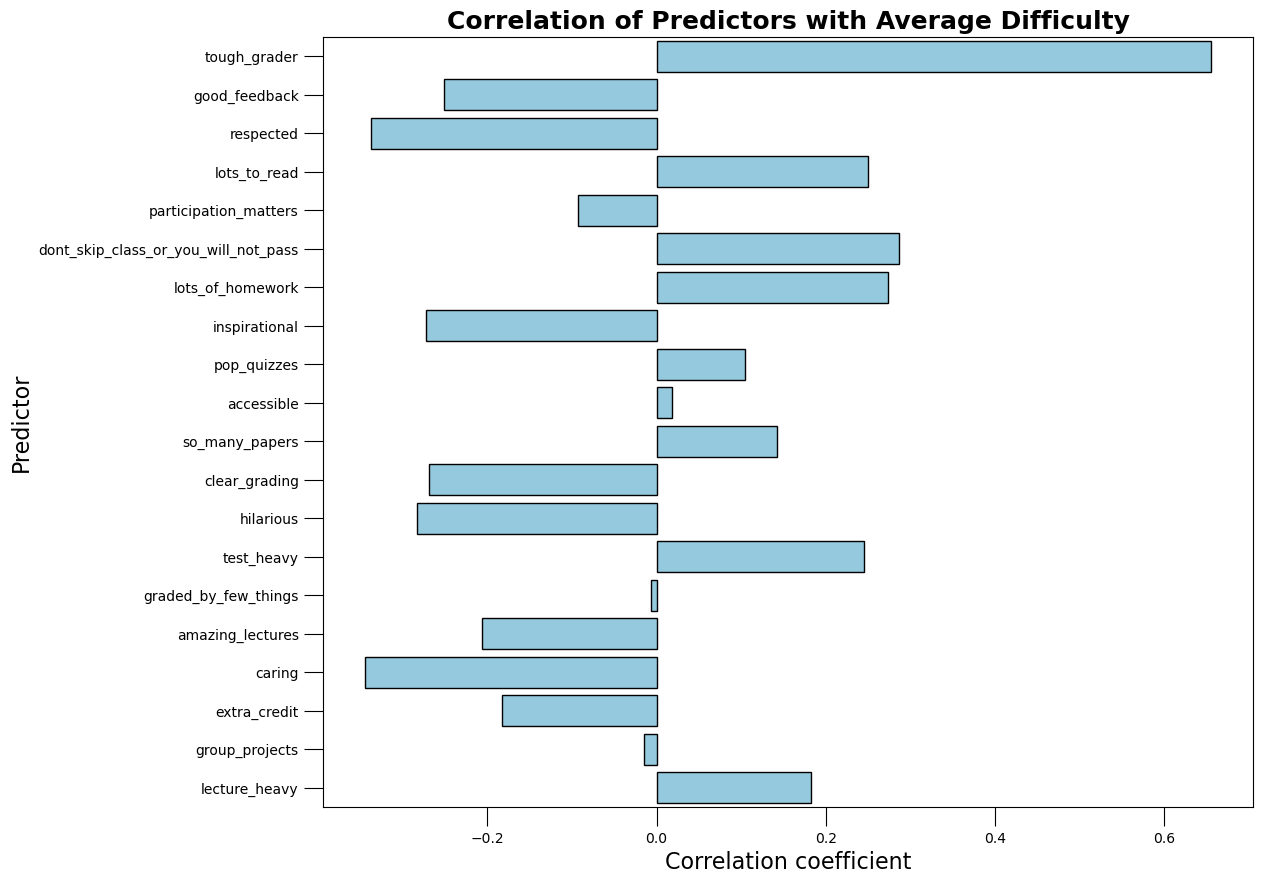

In [184]:
# plot correlation of y and x 
plt.figure(figsize= (12, 10))

# plot itself 
sns.barplot(corr_yx, 
            orient= 'h', 
            color = 'skyblue', 
            edgecolor = 'black')

# title 
plt.title("Correlation of Predictors with Average Difficulty", 
          fontsize = 18, 
          fontweight = "bold")

# xlabel
plt.xlabel("Correlation coefficient", 
           fontsize = 16)
# ylabel 
plt.ylabel("Predictor", 
           fontsize = 16)
# ticks 
plt.tick_params(size = 14)

Most of the variables have weak correlation with dependent variable. `Tough Grader` is the only variable that has strong positive correlation with `Average Difficulty`, which is approximately ~0.65. 

In [185]:
# predictors only
x = df_9.drop(columns="average_difficulty")

# correlation matrix among tags
corr_xx = x.corr()

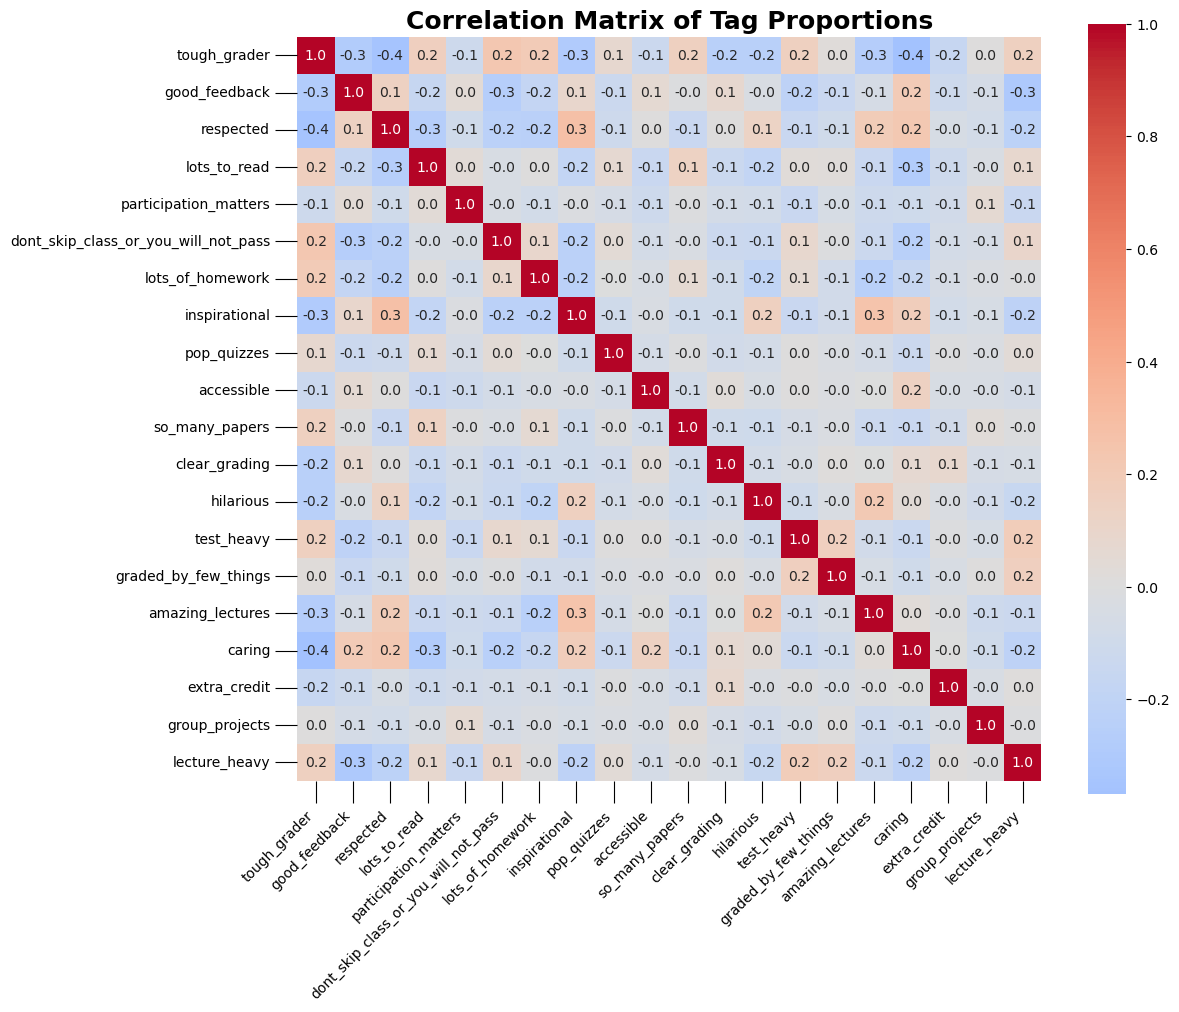

In [186]:
# plot correlation between predictors 
plt.figure(figsize= (12, 10))

# plot itself
sns.heatmap(
    corr_xx,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar=True,
    annot=True,
    fmt=".1f"
)

# title 
plt.title("Correlation Matrix of Tag Proportions", 
          fontweight = 'bold', 
          fontsize = 18)

# tickts 
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tick_params(size = 16)

plt.show()

We highlight multicollinearity only if the correlation between independent variables is >= 0.85. No multicollinearity was identified, which means that we do not have to fit ridge regression. 

In [ ]:
# model with all variables 
# pipeline for model 
pipeline_q9 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# cross-validation 
cv = KFold(n_splits=5, 
           shuffle=True, 
           random_state=n_number)
z
# run cross-validation
cv_results_raw = cross_validate(
    pipeline_q9,
    x_train,
    y_train,
    cv=cv,
    scoring=("r2", "neg_root_mean_squared_error"),
    return_train_score=False
)

cv_results = {
    "R2_mean": cv_results_raw["test_r2"].mean(),
    "RMSE_mean": (-cv_results_raw["test_neg_root_mean_squared_error"]).mean()
}

cv_results

{'R2_mean': 0.5505261434243346, 'RMSE_mean': 0.5406556834587964}

In [190]:
# fit the data 
pipeline_q9.fit(x_train, y_train)

# predict 
y_test_pred = pipeline_q9.predict(x_test)

# evaluate
r2_test = r2_score(y_test, y_test_pred)
rmse_test = root_mean_squared_error(y_test, 
                                    y_test_pred)

# test results 
test_results = {
    "R2": r2_test, 
    "RMSE": rmse_test
}

# check 
test_results



{'R2': 0.5472489239116027, 'RMSE': 0.5413209790590664}

In [191]:
# check coefficients of the model
coef = pipeline_q9.named_steps["model"].coef_

# coefficients in a dataframe
weights_df = pd.DataFrame({
    "tag": x_train.columns,
    "weight": coef
}).sort_values("weight", ascending=False)

# sort by magnitude 
weights_df = weights_df.reindex(weights_df["weight"].abs().sort_values(ascending=False).index)

In [192]:
# check 
weights_df

,tag,weight
0,tough_grader,0.243408
11,clear_grading,-0.175670
12,hilarious,-0.173724
16,caring,-0.165308
17,extra_credit,-0.149399
2,respected,-0.136690
1,good_feedback,-0.124951
4,participation_matters,-0.122437
7,inspirational,-0.096854
18,group_projects,-0.086884


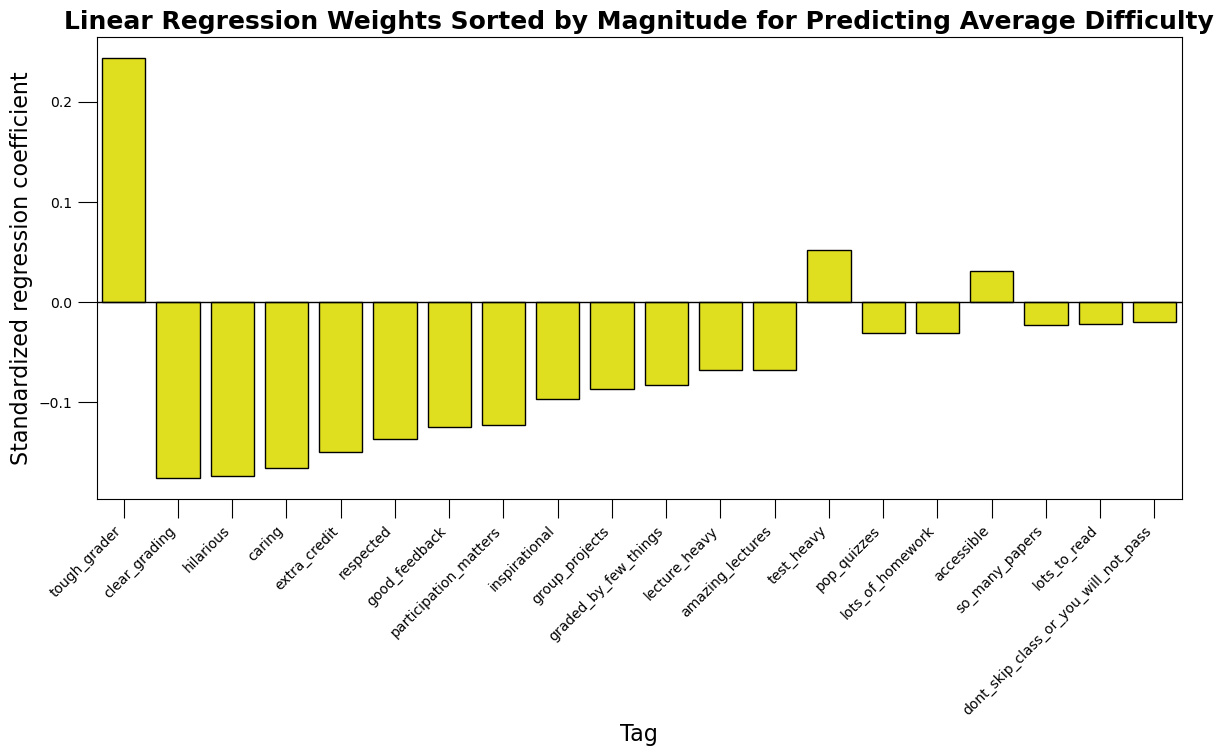

In [193]:
# Plot weights (coefficients)
# figure size 
plt.figure(figsize=(14, 6))

# plot itself 
sns.barplot(
    data=weights_df,
    x="tag",
    y="weight",
    color="yellow",
    edgecolor="black"
)

# horizontal line
plt.axhline(0, color="black", linewidth=1)

# title 
plt.title("Linear Regression Weights Sorted by Magnitude for Predicting Average Difficulty", 
          fontsize = 18, 
          fontweight = "bold")

# xlabel 
plt.xlabel("Tag", fontsize = 16)
# ylabel
plt.ylabel("Standardized regression coefficient", 
           fontsize = 16)

# ticks
plt.xticks(rotation=45, ha="right")
plt.tick_params(size = 14)

# show the plot 
plt.show()

We built a linear regression model to predict average course difficulty using all tag proportions as predictors. Model performance was evaluated using 5-fold cross-validation on the training set and a held-out test set. The model achieved a cross-validated R² of 0.55 and RMSE of 0.54, and a test-set R² of 0.54 with RMSE of 0.54, indicating stable generalization and no evidence of overfitting. An RMSE of about 0.54 means the model's predictions deviate from observed average difficulty ratings by roughly half a rating point on average, which is reasonable given the subjective and noisy nature of difficulty ratings.

Based on the standardized regression coefficients, the tag most strongly predictive of average difficulty is tough_grader, which has by far the largest positive weight. This indicates that courses more frequently tagged as "tough grader" are predicted to be substantially more difficult, even after controlling for all other tags. Several tags such as clear_grading, hilarious, caring, and extra_credit show negative coefficients, suggesting associations with lower perceived difficulty when holding other tags constant. Pairwise correlations among tags are uniformly low, indicating no multicollinearity concerns. For these reasons, regularized models such as Ridge or Lasso were unnecessary, and an unregularized linear regression model was appropriate.

## Q10. Build a classification model that predicts whether a professor receives a “pepper” from all available factors (both tags and numerical). Make sure to include model quality metrics such as AU(RO)C and also address class imbalance concerns.

In [210]:
# first, make a subset of all variables that are needed. 
df_10 = df_filtered_final.copy()

# check 
df_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        18422 non-null  float64
 1   average_difficulty                    18422 non-null  float64
 2   number_of_ratings                     18422 non-null  float64
 3   received_a_pepper                     18422 non-null  float64
 4   would_take_again                      8849 non-null   float64
 5   number_of_ratings_online              18422 non-null  float64
 6   male_gender                           18422 non-null  int64  
 7   female_gender                         18422 non-null  int64  
 8   major                                 18422 non-null  object 
 9   university                            18422 non-null  object 
 10  state                                 18422 non-null  object 
 11  tough_grader        

In [211]:
# drop female_gender as it is redundant 
df_10 = df_10.drop(columns = ['female_gender', 
                            'major', 
                            'university', 
                            'state'])
# check 
df_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18422 entries, 5 to 89890
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   average_rating                        18422 non-null  float64
 1   average_difficulty                    18422 non-null  float64
 2   number_of_ratings                     18422 non-null  float64
 3   received_a_pepper                     18422 non-null  float64
 4   would_take_again                      8849 non-null   float64
 5   number_of_ratings_online              18422 non-null  float64
 6   male_gender                           18422 non-null  int64  
 7   tough_grader                          18422 non-null  float64
 8   good_feedback                         18422 non-null  float64
 9   respected                             18422 non-null  float64
 10  lots_to_read                          18422 non-null  float64
 11  participation_matter

We can see 8849 null values. We can deal with them during model fit phase, imputing null values with KNN. 

In [216]:
# correlations between y and x predictors 
corr_yx_10 = df_10.corr()["received_a_pepper"].drop("received_a_pepper")

# check 
corr_yx_10.sort_values(ascending=False)

average_rating                          0.454494
would_take_again                        0.433403
amazing_lectures                        0.250208
inspirational                           0.245123
respected                               0.230408
hilarious                               0.191124
caring                                  0.190178
good_feedback                           0.188749
number_of_ratings                       0.106095
clear_grading                           0.043615
extra_credit                            0.032502
accessible                              0.032005
participation_matters                   0.004747
number_of_ratings_online               -0.008278
male_gender                            -0.016829
pop_quizzes                            -0.057046
group_projects                         -0.071418
so_many_papers                         -0.107933
graded_by_few_things                   -0.114131
lots_to_read                           -0.136564
test_heavy          

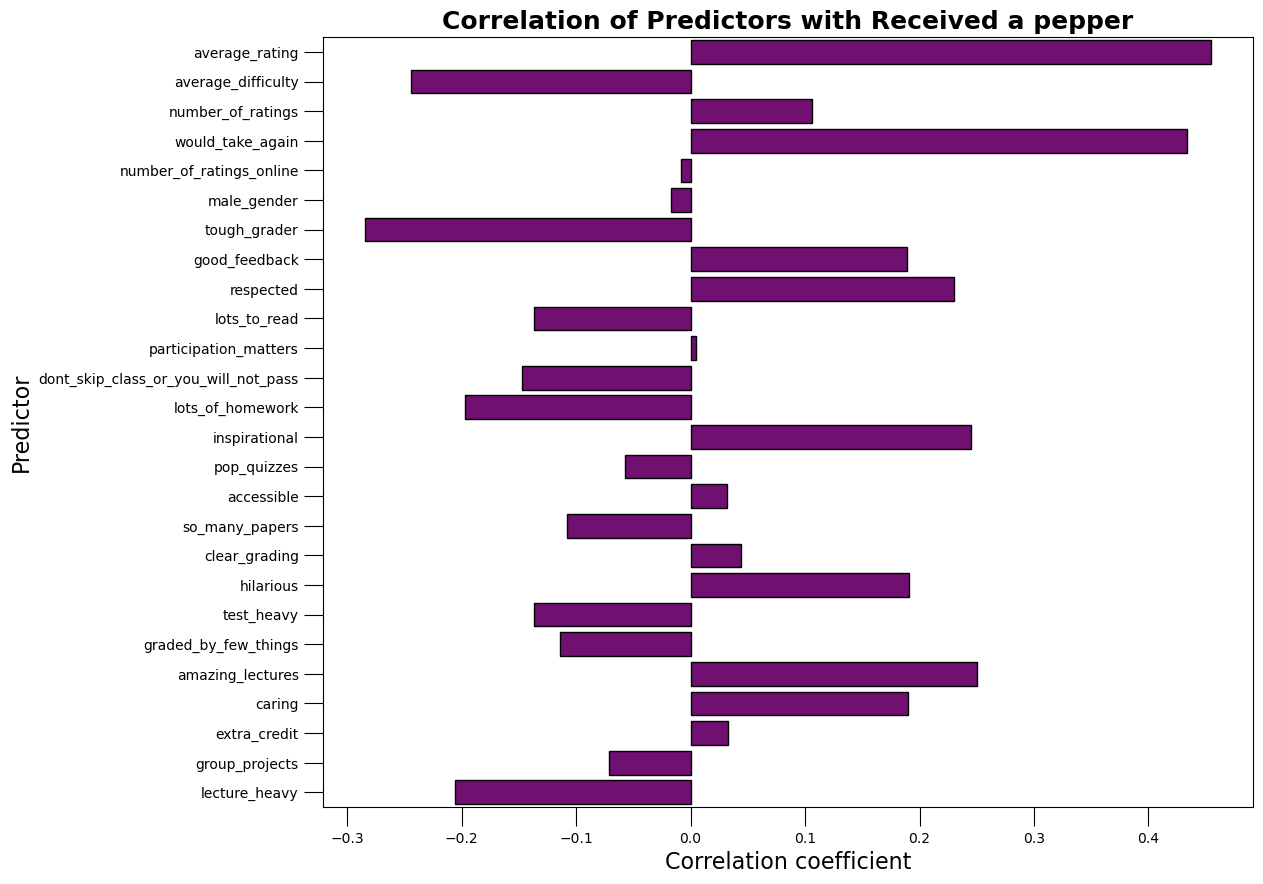

In [217]:
# plot correlation of y and x 
plt.figure(figsize= (12, 10))

# plot itself 
sns.barplot(corr_yx_10, 
            orient= 'h', 
            color = 'purple', 
            edgecolor = 'black')

# title 
plt.title("Correlation of Predictors with Received a pepper", 
          fontsize = 18, 
          fontweight = "bold")

# xlabel
plt.xlabel("Correlation coefficient", 
           fontsize = 16)
# ylabel 
plt.ylabel("Predictor", 
           fontsize = 16)
# ticks 
plt.tick_params(size = 14)

Only average rating (~0.45) and would take again (0.43) have a strong correlation with dependent variable. Now let's explore multicollinearity. 

In [219]:
# separate into x and y 
# separate y (dependent variable) and x(independent variables)
y = df_10["received_a_pepper"]
x = df_10.drop(columns = "received_a_pepper")

# correlation matrix among tags
corr_xx = x.corr()

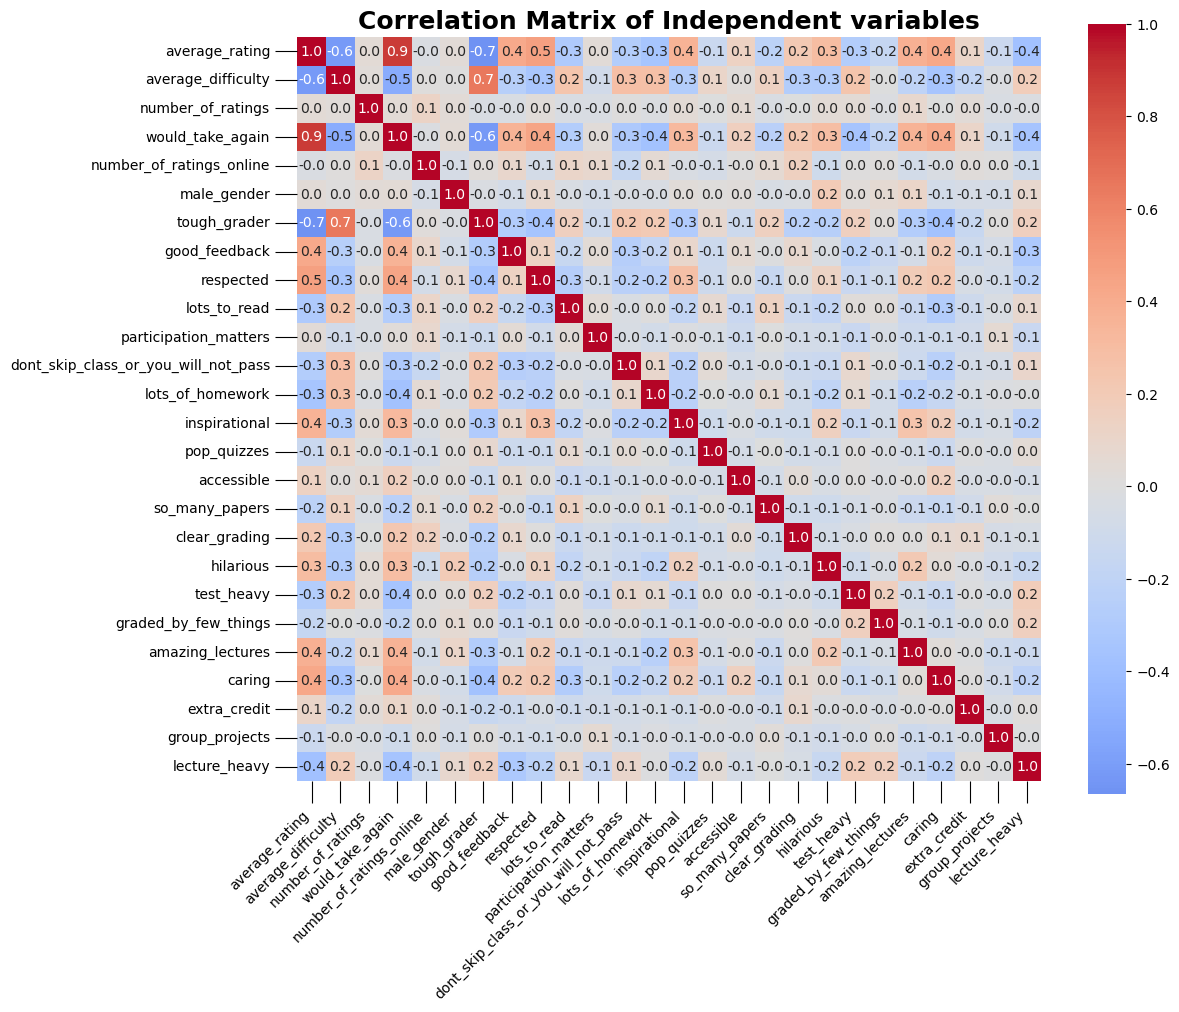

In [275]:
# plot correlation between predictors 
plt.figure(figsize= (12, 10))

# plot itself
sns.heatmap(
    corr_xx,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar=True,
    annot=True,
    fmt=".1f"
)

# title 
plt.title("Correlation Matrix of Independent variables", 
          fontweight = 'bold', 
          fontsize = 18)

# tickts 
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tick_params(size = 16)

plt.show()

Would take again and average rating variables are highly multicollinear with each other. We will need to fit ridge logistic regression to combat multicollinearity. Before we start building the model, we want to adress class imbalance. 

In [222]:
# split the the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=n_number)

# check distributions of the data 
print(f'Number of rows for train data:{y_train.shape[0]}\n')
print(f'Number of rows for test data:{y_test.shape[0]}\n')

Number of rows for train data:14737

Number of rows for test data:3685



In [227]:
# check classes in train data
y_train.value_counts()

received_a_pepper
0.0    8504
1.0    6233
Name: count, dtype: int64

Both classes are well represented. We will fit the model now. 

In [277]:
# model pipeline
pipeline_q10_ridge_cv = Pipeline([
    ("imputer", KNNImputer(n_neighbors=10)),
    ("scaler", StandardScaler()),
    ("model", LogisticRegressionCV(
        penalty="l2",
        Cs=np.logspace(-4, 4, 20),
        cv=5,
        max_iter=1000
    ))
])

# cross-validation parameters 
cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=n_number
)

# apply cross-validation
cv_results_raw = cross_validate(
    pipeline_q10_ridge_cv,
    x_train,
    y_train,
    cv=cv,
    scoring=("roc_auc", "recall", "precision", "f1"),
    return_train_score=False
)

# results 
cv_results = {
    "AUC_mean": cv_results_raw["test_roc_auc"].mean(),
    "Recall_mean": cv_results_raw["test_recall"].mean(),
    "Precision_mean": cv_results_raw["test_precision"].mean(),
    "F1_mean": cv_results_raw["test_f1"].mean()
}

# check 
cv_results


{'AUC_mean': 0.7901350007483801,
 'Recall_mean': 0.6791107990640107,
 'Precision_mean': 0.6598474754800658,
 'F1_mean': 0.6690099370899625}

In [278]:
# fit the data 
pipeline_q10_ridge_cv.fit(x_train, y_train)

# predict labels
y_test_pred = pipeline_q10_ridge_cv.predict(x_test)

# predict probabilities for ROC AUC
y_test_prob = pipeline_q10_ridge_cv.predict_proba(x_test)[:, 1]

# metrics
auc_test = roc_auc_score(y_test, y_test_prob)
recall_test = recall_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)


# results
test_results = {
    "ROC_AUC": auc_test, 
    "Recall": recall_test, 
    "precision_score": precision_test, 
    "F1": f1_test

}

test_results


{'ROC_AUC': 0.7929513470189398,
 'Recall': 0.692258883248731,
 'precision_score': 0.6636253041362531,
 'F1': 0.677639751552795}

In [279]:
# classification summary
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.7624    0.7378    0.7499      2109
         1.0     0.6636    0.6923    0.6776      1576

    accuracy                         0.7183      3685
   macro avg     0.7130    0.7150    0.7138      3685
weighted avg     0.7201    0.7183    0.7190      3685



Cross-validation on the training data yields a mean AUROC of 0.79, with recall, precision, and F1 scores all around 0.66-0.68. These values indicate that the model has good discriminative ability and balanced performance when identifying professors who received a pepper, while still generalizing across folds. When evaluated on the held-out test set, performance remains highly consistent, with an AUROC of 0.79, recall of 0.69, precision of 0.66, and F1 score of 0.68. The close agreement between cross-validated training metrics and test-set metrics suggests that the model generalizes well and does not suffer from overfitting.

The classification report shows that the model correctly identifies a substantial fraction of professors who received a pepper, while maintaining reasonable precision. Accuracy is approximately 0.72, which is meaningful given the subjective nature of the outcome and the moderate overlap between classes. Performance is comparable across classes, as reflected by similar macro-averaged and weighted-averaged metrics.

Having established that the model performs well and discriminates well between pepper and non-pepper professors, we next examine the confusion matrix to explicitly quantify false positives and false negatives, followed by the ROC curve to visualize the tradeoff between sensitivity and specificity across thresholds.

<Figure size 1200x1000 with 0 Axes>

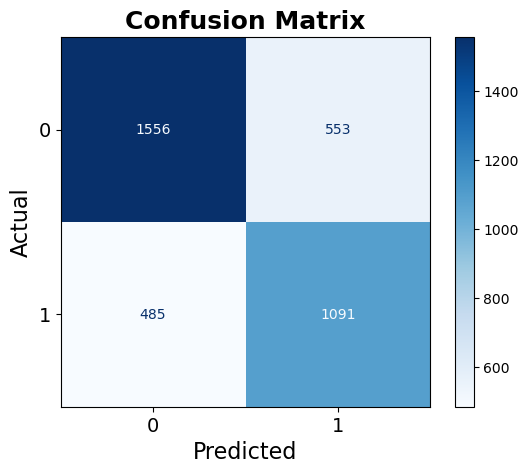

In [280]:
# confusion matrix 
cm = confusion_matrix(y_test, y_test_pred)

# figure size 
plt.figure(figsize=(12, 10))

# confusion matrix parameters 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

# title 
plt.title("Confusion Matrix", fontsize=18, fontweight="bold")

# xlabel
plt.xlabel("Predicted", fontsize=16)
#ylabel
plt.ylabel("Actual", fontsize=16)

# ticks
plt.tick_params(labelsize=14)

plt.show()

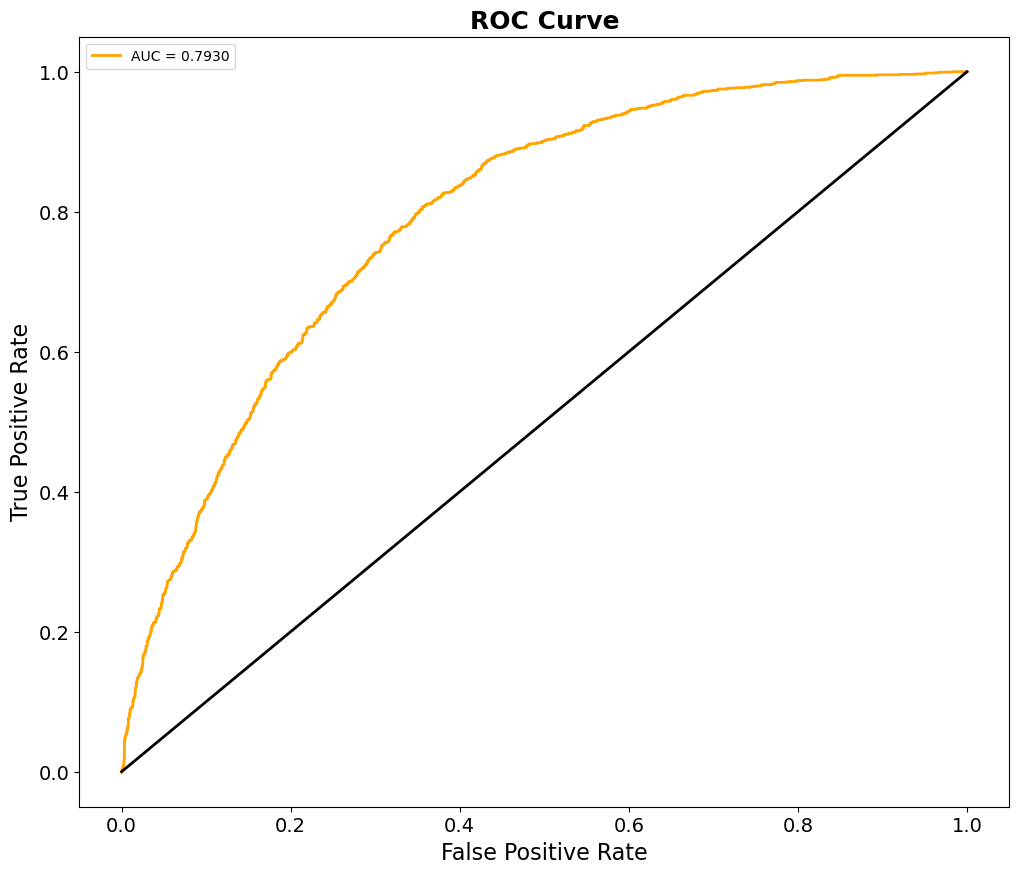

In [289]:
# extract false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
# compute roc_auc
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(12, 10))

# plot itself
plt.plot(fpr, tpr, color="orange", linewidth=2, label=f"AUC = {roc_auc:.4f}")
# mean line
plt.plot([0, 1], [0, 1], color="black", linewidth=2)

# title 
plt.title("ROC Curve", fontsize=18, fontweight="bold")

# xlabel
plt.xlabel("False Positive Rate", fontsize=16)

# ylabel
plt.ylabel("True Positive Rate", fontsize=16)

# tickparams
plt.tick_params(labelsize=14)

# legend
plt.legend(frameon = True, 
           loc = 'upper left')

# show the plot
plt.show()

The confusion matrix shows that the model correctly identifies 1,091 professors who received a pepper and 1,556 who did not. There are 485 false negatives, professors who received a pepper but were missed, and 553 false positives, professors incorrectly flagged as having received a pepper. Given our stated objective that false negatives are more costly than false positives, this error profile is acceptable. The model captures a large share of true pepper recipients while tolerating some overprediction.

Next, we fine-tune the decision threshold to further reduce false negatives by prioritizing recall, and examine how recall and precision trade off across different thresholds before selecting the final operating point. From our perspective, false negatives are more costly than false positives. A false negative corresponds to a professor who actually received a pepper but is not identified by the model, meaning we fail to recognize a genuinely high-quality instructor. In contrast, a false positive only results in incorrectly flagging a professor who did not receive a pepper, which is less harmful in this context. For this reason, we prioritize maximizing recall for the positive class. By adjusting the decision threshold, we aim to capture as many true pepper recipients as possible, even if this increases the number of false positives, and then select an operating point that maintains reasonable precision while minimizing missed positive cases.

In [284]:
# predicted probabilities on train set
y_train_prob = pipeline_q10_ridge_cv.predict_proba(x_train)[:, 1]

# thresholds
thresholds = np.linspace(0.01, 0.99, 50)
rows = []

# loop over many thresholds
for t in thresholds:
    y_pred_t = (y_train_prob >= t).astype(int)
    rows.append({
        "threshold": t,
        "recall": recall_score(y_train, y_pred_t),
        "precision": precision_score(y_train, y_pred_t),
        "f1": f1_score(y_train, y_pred_t)
    })

# check 
threshold_df_train = pd.DataFrame(rows)
threshold_df_train


,threshold,recall,precision,f1
0,0.01,1.000000,0.423783,0.595292
1,0.03,0.999679,0.437662,0.608793
2,0.05,0.997433,0.452837,0.622883
3,0.07,0.992459,0.465463,0.633714
4,0.09,0.985721,0.477093,0.642980
5,0.11,0.978181,0.487799,0.650972
6,0.13,0.970319,0.498475,0.658608
7,0.15,0.962458,0.508821,0.665705
8,0.17,0.954115,0.518709,0.672053
9,0.19,0.944168,0.527803,0.677098


Choosing a threshold of 0.35 reflects a deliberate preference for high recall. At this operating point, the model achieves a recall of ~0.85, meaning it correctly identifies about 85 percent of professors who received a pepper. Precision is ~0.60, indicating that a majority of professors flagged as pepper recipients are indeed true positives. The resulting F1 score of ~0.70 shows a strong overall balance between recall and precision while still emphasizing sensitivity to the positive class. This threshold substantially reduces false negatives compared to higher thresholds and aligns with our objective of minimizing missed pepper recipients, even at the cost of accepting additional false positives.

In [285]:
# apply chosen threshold
threshold = 0.35
y_test_prob = pipeline_q10_ridge_cv.predict_proba(x_test)[:, 1]
y_test_pred = (y_test_prob >= threshold).astype(int)

In [286]:
# final results 
final_results = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "F1": f1_score(y_test, y_test_pred),
    "AUROC": roc_auc_score(y_test, y_test_prob)
}

# check 
final_results

{'Accuracy': 0.6985074626865672,
 'Recall': 0.8521573604060914,
 'Precision': 0.6046825754164791,
 'F1': 0.7074005794047933,
 'AUROC': 0.7929513470189398}

In [290]:
# classification summary
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.8408    0.5837    0.6891      2109
         1.0     0.6047    0.8522    0.7074      1576

    accuracy                         0.6985      3685
   macro avg     0.7228    0.7179    0.6982      3685
weighted avg     0.7398    0.6985    0.6969      3685



In [292]:
# check the results
# classification report as dict
report_dict = classification_report(
    y_test,
    y_test_pred,
    digits=4,
    output_dict=True
)

# dataframe (rows = classes/averages, cols = metrics)
results_q10_df = pd.DataFrame(report_dict).T

# style with borders
styled1 = results_q10_df.style.set_properties(**{
    "background-color": "white",
    "color": "black",
    "border": "1px solid black"
}).format("{:.4f}")

styled1

,precision,recall,f1-score,support
0.0,0.8408,0.5837,0.6891,2109.0000
1.0,0.6047,0.8522,0.7074,1576.0000
accuracy,0.6985,0.6985,0.6985,0.6985
macro avg,0.7228,0.7179,0.6982,3685.0000
weighted avg,0.7398,0.6985,0.6969,3685.0000


<Figure size 1200x1000 with 0 Axes>

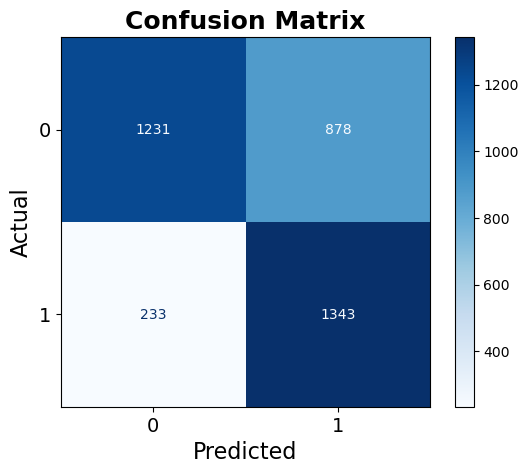

In [293]:
# confusion matrix 
cm = confusion_matrix(y_test, y_test_pred)

# figure size 
plt.figure(figsize=(12, 10))

# confusion matrix parameters 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

# title 
plt.title("Confusion Matrix", fontsize=18, fontweight="bold")

# xlabel
plt.xlabel("Predicted", fontsize=16)
#ylabel
plt.ylabel("Actual", fontsize=16)

# ticks
plt.tick_params(labelsize=14)

plt.show()

With the decision threshold set to 0.35, the model successfully shifts its behavior toward prioritizing recall for the positive class. The confusion matrix shows that 1,343 professors who received a pepper are correctly identified, while false negatives are reduced to 233, a substantial improvement compared to the default threshold. This aligns with our objective of minimizing missed pepper recipients. As expected, this comes at the cost of more false positives, with 878 non-pepper professors incorrectly flagged.

The classification report confirms this tradeoff. For the positive class, recall increases to 0.85, meaning the model now captures the vast majority of true pepper recipients, while precision remains moderate at 0.60. The resulting F1 score of 0.71 reflects a strong balance between sensitivity and precision under a recall-oriented operating point. Overall accuracy decreases slightly, which is expected when prioritizing recall, but the model remains effective for the intended goal. This final threshold represents a well-justified operating point given the higher cost of false negatives in this setting.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy.stats import mannwhitneyu, kstest, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from math import sqrt

In [ ]:
df = pd.read_csv("../data/processed/filtered_records.csv")
seed = 12250697

## Question 5

In [ ]:
# Get difficulties of male and females
difficulty_male = df["average_difficulty"].loc[df["male_gender"] == 1]
difficulty_female = df["average_difficulty"].loc[df["female_gender"] == 1]

# create list for difficulties of all gender combinations
gender_counts = [
    ((df["male_gender"] == 1) & (df["female_gender"] == 0)).sum(),
    ((df["male_gender"] == 0) & (df["female_gender"] == 1)).sum(),
    ((df["male_gender"] == 1) & (df["female_gender"] == 1)).sum(),
    ((df["male_gender"] == 0) & (df["female_gender"] == 0)).sum(),
]

# list of gender categories
gender_categories = [
    "Only Male",
    "Only Female",
    "Both",
    "None"
]

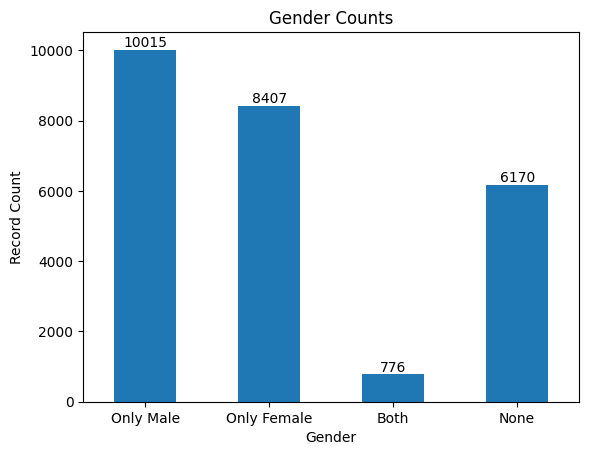

In [ ]:
# Plot counts of participant genders
x_values = gender_categories
y_values = gender_counts

df_bars = pd.DataFrame({
        "x": x_values,
        "y": y_values
    })

ax = df_bars.plot(kind="bar", x="x", y="y", legend=False)  # Bar plot
ax.bar_label(ax.containers[0])  # Add value labels on top of each bar
plt.xticks(rotation=-0)  # Keep x tick labels horizontal
plt.title("Gender Counts")
plt.xlabel("Gender")
plt.ylabel("Record Count")
plt.show()

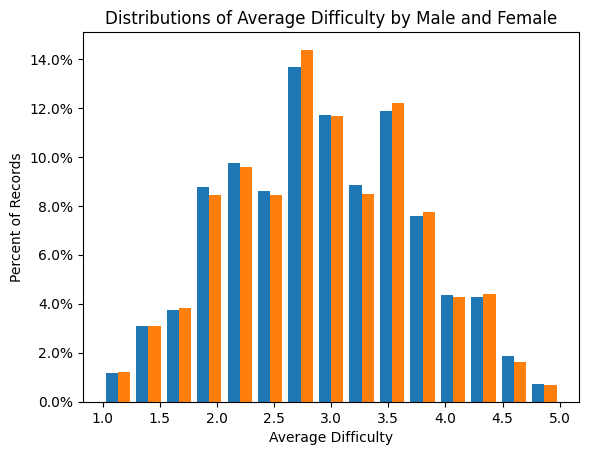

In [ ]:
average_difficulty_columns = "average_difficulty"  # Column name for shrek movies
shrek_reviews_female = df[average_difficulty_columns].loc[df["male_gender"] == 1]  # Split into male reviews
shrek_reviews_male = df[average_difficulty_columns].loc[df["female_gender"] == 1]  # Split into female reviews

plt.hist(
    [shrek_reviews_male, shrek_reviews_female],
    bins=15, 
    weights=[
        np.ones(len(shrek_reviews_male)) / len(shrek_reviews_male), 
        np.ones(len(shrek_reviews_female)) / len(shrek_reviews_female)
    ]
)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Average Difficulty")
plt.ylabel("Percent of Records")
plt.title("Distributions of Average Difficulty by Male and Female")
plt.show()

In [ ]:
U1, p = mannwhitneyu(shrek_reviews_male, shrek_reviews_female)
print(f"U statistic is {U1}")
print(f"p-value is {p}")

U statistic is 49456604.5
p-value is 0.8239822648687855


In [ ]:
print(f"Male average difficulty median {shrek_reviews_male.median()}")
print(f"Female average difficulty median {shrek_reviews_female.median()}")

Male average difficulty median 2.9
Female average difficulty median 2.9


In [ ]:
ranked_difficulties = df["average_difficulty"].rank(method="average")
ranked_difficulties_male = df["average_difficulty"].loc[df["male_gender"] == 1]
ranked_difficulties_female = df["average_difficulty"].loc[df["female_gender"] == 1]

print(f"Male average rank {ranked_difficulties_male.mean()}")
print(f"Female average rank {ranked_difficulties_female.mean()}")

Male average rank 2.900963766101381
Female average rank 2.899989110312534


## Question 7

In [ ]:
def score_model(model, X_train, X_test, y_train, y_test):
    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)

    #r2_score
    train_r2 = r2_score(y_train, y_train_hat)
    test_r2 = r2_score(y_test, y_test_hat)

    #mse
    train_rmse = sqrt(mean_squared_error(y_train, y_train_hat))
    test_rmse = sqrt(mean_squared_error(y_test, y_test_hat))

    out = {
        "Training RMSE": train_rmse,
        "Training R2": train_r2,
        "Testing RMSE": test_rmse,
        "Testing R2": test_r2
    }

    return out

In [ ]:
df.isna().sum()

average_rating                              0
average_difficulty                          0
number_of_ratings                           0
received_a_pepper                           0
would_take_again                        13208
number_of_ratings_online                    0
male_gender                                 0
female_gender                               0
major                                       0
university                                  0
state                                       0
tough_grader                                0
good_feedback                               0
respected                                   0
lots_to_read                                0
participation_matters                       0
dont_skip_class_or_you_will_not_pass        0
lots_of_homework                            0
inspirational                               0
pop_quizzes                                 0
accessible                                  0
so_many_papers                    

### Preprocessing

1. Split into training and testing subsets
2. Scale data
3. Fill nulls in would_take_again field using KNN imputation
4. Heatmap to show correlations

In [ ]:
# Define training and testing sets
y = df["average_rating"]
X = df[[
    "average_difficulty",
    "number_of_ratings",
    "received_a_pepper",
    "would_take_again",
    "number_of_ratings_online",
    "male_gender",
    "female_gender",
]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
# Fill in na values via imputation
# would_take_again_median = X_train.median()
# X_train["would_take_again"] = X_train["would_take_again"].fillna(would_take_again_median)
# X_test["would_take_again"] = X_test["would_take_again"].fillna(would_take_again_median)

In [ ]:
# Scale data - fit on training data, transform both training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Impute data using k nearest neighbor imputation
imputer = KNNImputer(n_neighbors=10)
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

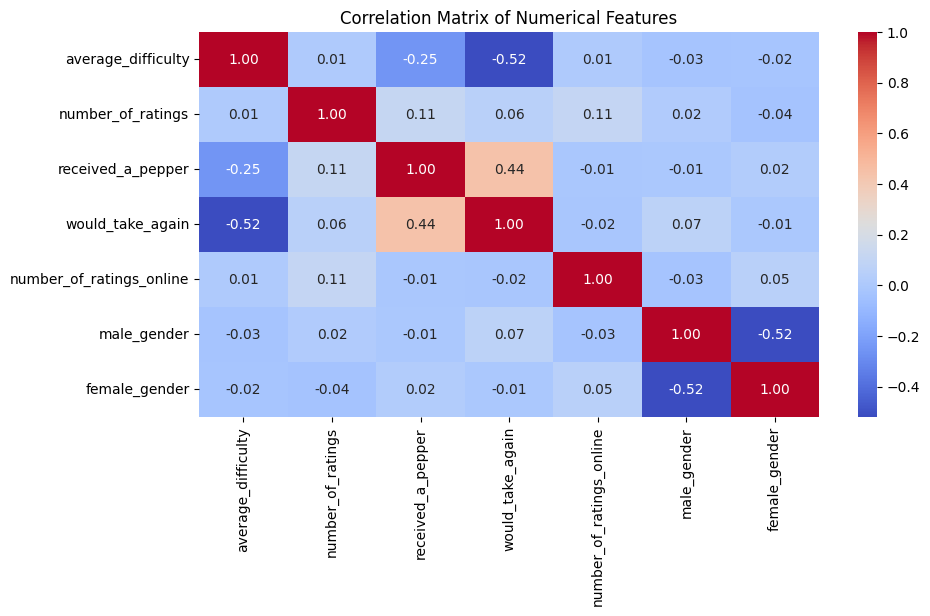

In [ ]:
# Correlation matrix
corr = X_train.corr()

# 3. Plot the heatmap using Seaborn
plt.figure(figsize=(10, 5)) # Adjust the figure size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Simple Linear Regression

In [ ]:
# simple linear regression
model = LinearRegression().fit(X_train_scaled, y_train)
simple_linear_model_scores = score_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
print(simple_linear_model_scores)

{'Training RMSE': 0.5827966106018181, 'Training R2': 0.6219040362662225, 'Testing RMSE': 0.5951869506417504, 'Testing R2': 0.6016598351966275}


[-0.24186074  0.01559851  0.12857317  0.57353188 -0.00545727  0.02576412
  0.02170311]


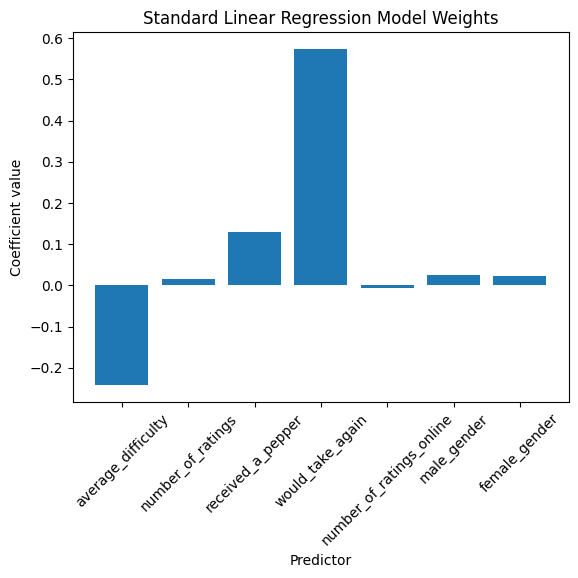

In [ ]:
simple_linear_model_coefficients = model.coef_
print(simple_linear_model_coefficients)
plt.bar(X.columns, simple_linear_model_coefficients)
plt.xlabel("Predictor")
plt.ylabel("Coefficient value")
plt.xticks(rotation=45)
plt.title("Standard Linear Regression Model Weights")
plt.show()

 ### Ridge Regression

In [ ]:
def alpha_search(alg, alphas):
    rmses = []
    r_squareds = []

    for alpha in alphas:
        # fit model
        model = alg(alpha=alpha, random_state=seed)
        model.fit(X_train_scaled, y_train)

        # Assess model
        scores = score_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
        rmses.append(scores["Training RMSE"])
        r_squareds.append(scores["Training R2"])
    
    # Get minimum mean squared error
    minimum_mse = min(rmses)
    minimum_mse_index = rmses.index(minimum_mse)  # index of minimum mean squared error
    best_alpha = alphas[minimum_mse_index]

    # Return output as dictionary
    return {
        "alphas": alphas,
        "training_rmses": rmses,
        "training_r2s": r_squareds,
        "best_alpha": best_alpha,
        "minimum_rmse": minimum_mse
    }


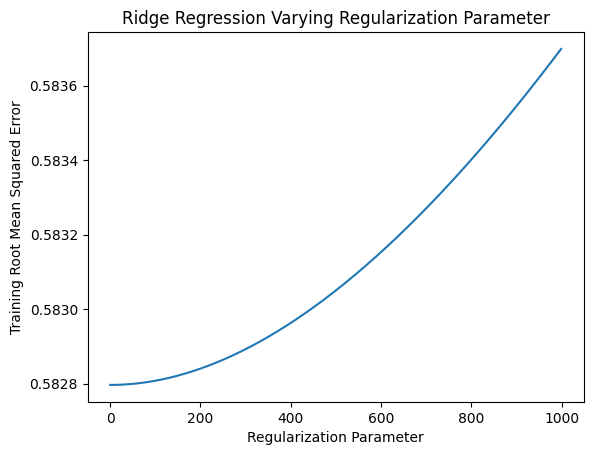

In [ ]:
# Ridge regression
alphas = np.arange(0, 1000, 1)
out = alpha_search(Ridge, alphas)

plt.plot(out["alphas"], out["training_rmses"])
plt.xlabel("Regularization Parameter")
plt.ylabel("Training Root Mean Squared Error")
plt.title("Ridge Regression Varying Regularization Parameter")
plt.show()

### Lasso Regression

/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.446e+03, tolerance: 1.823e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/R

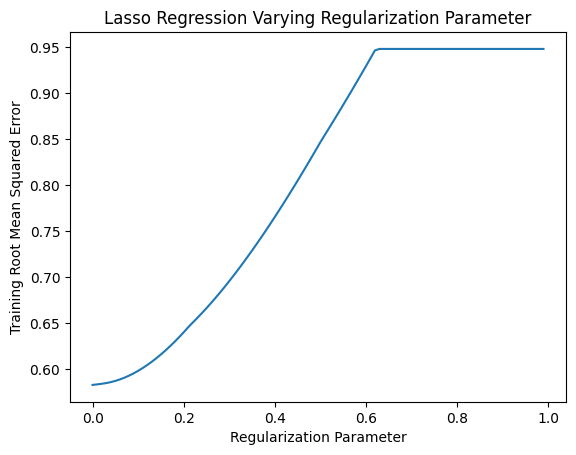

In [ ]:
# Lasso regression
alphas = np.arange(0.00, 1, 0.01)
out = alpha_search(Lasso, alphas)

plt.plot(alphas, out["training_rmses"])
plt.xlabel("Regularization Parameter")
plt.ylabel("Training Root Mean Squared Error")
plt.title("Lasso Regression Varying Regularization Parameter")
plt.show()

## Question 8

### Preprocessing

1. Split into training and testing subsets
2. Scale data to have mean 0 and standard deviation of 1.
3. No nulls, so no need to impute data
4. Correlation plot

In [ ]:
df_tags_column_names = [
    "tough_grader",
    "good_feedback",
    "respected",
    "lots_to_read",
    "participation_matters",
    "dont_skip_class_or_you_will_not_pass",
    "lots_of_homework",
    "inspirational",
    "pop_quizzes",
    "accessible",
    "so_many_papers",
    "clear_grading",
    "hilarious",
    "test_heavy",
    "graded_by_few_things",
    "amazing_lectures",
    "caring",
    "extra_credit",
    "group_projects",
    "lecture_heavy"
]

In [ ]:
# Define training and testing sets
y = df["average_rating"]
X = df[df_tags_column_names]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
# Scale data - fit on training data, transform both training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

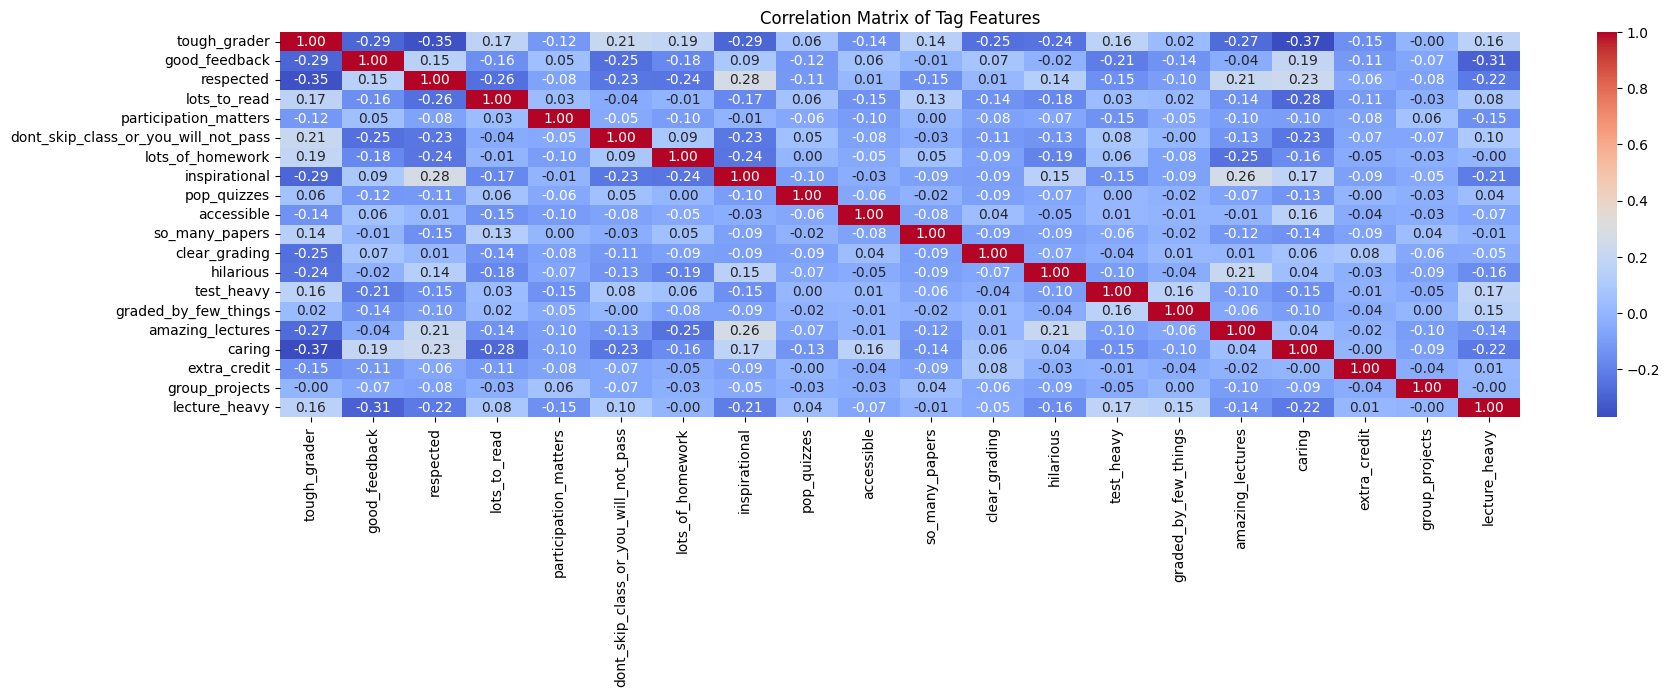

In [ ]:
# Correlation matrix
corr = X_train.corr()

# 3. Plot the heatmap using Seaborn
plt.figure(figsize=(20, 5)) # Adjust the figure size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Tag Features')
plt.show()

### Simple Linear Regression

In [ ]:
# simple linear regression
model = LinearRegression().fit(X_train_scaled, y_train)
simple_linear_model_scores = score_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
print(simple_linear_model_scores)

{'Training RMSE': 0.5073084685277204, 'Training R2': 0.7135081771925518, 'Testing RMSE': 0.5154148643262388, 'Testing R2': 0.7012821494837158}


[-0.14420925  0.31270779  0.24360265  0.0789572   0.14172583  0.1101547
  0.03274068  0.14859151  0.04550049  0.11052595 -0.01186806  0.18434158
  0.20632929 -0.0145268  -0.01318712  0.2514831   0.23190865  0.16162053
  0.02322572 -0.01598362]


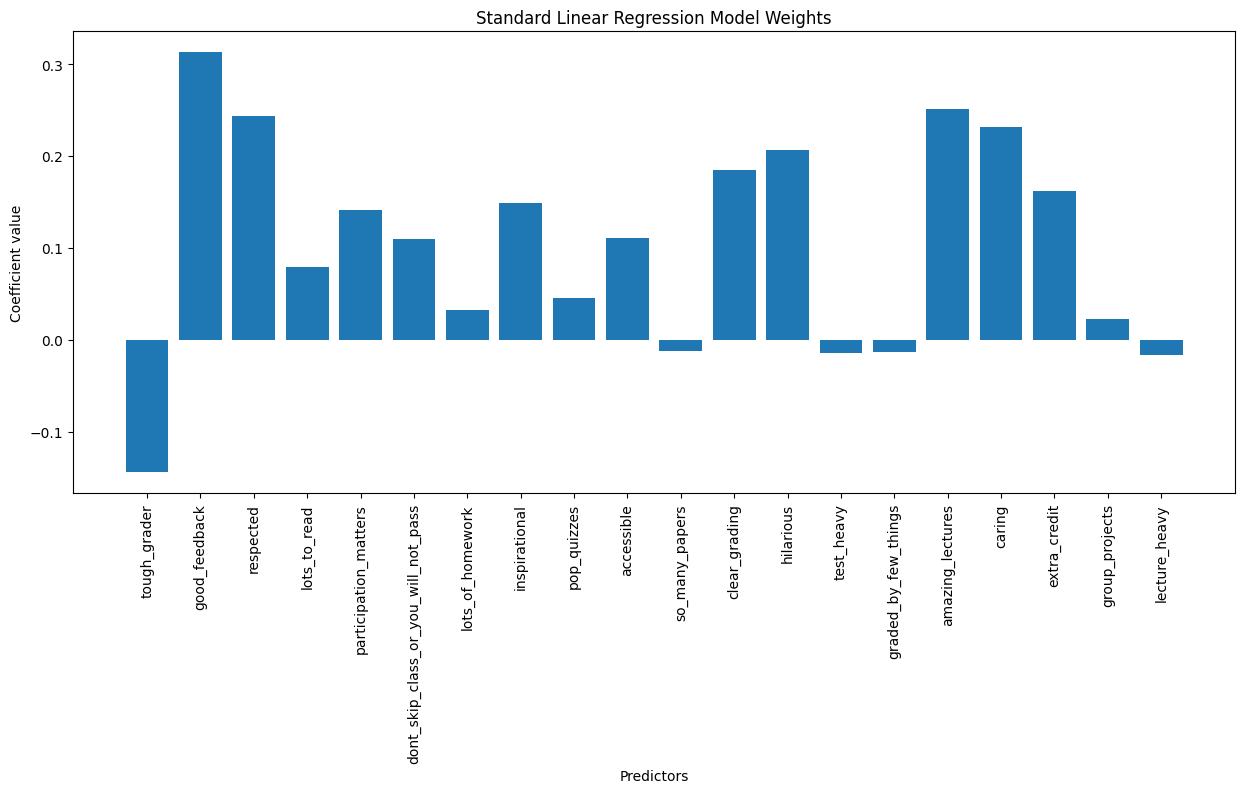

In [ ]:
simple_linear_model_coefficients = model.coef_
print(simple_linear_model_coefficients)
plt.figure(figsize=(15, 6))
plt.bar(X.columns, simple_linear_model_coefficients)
plt.xlabel("Predictors")
plt.ylabel("Coefficient value")
plt.xticks(rotation=90)
plt.title("Standard Linear Regression Model Weights")
plt.show()

### Ridge and Lasso Regression are less performant than simple linear regression

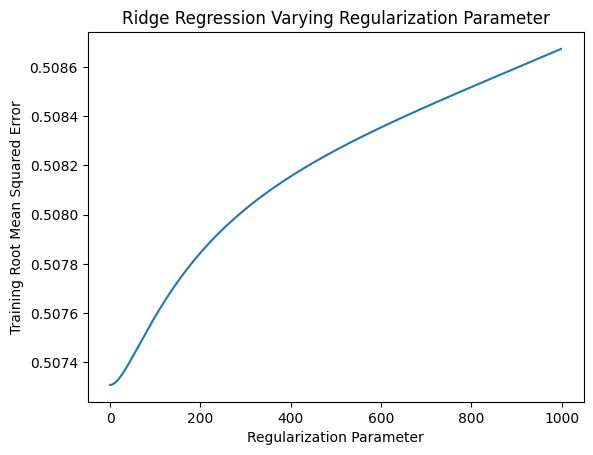

In [ ]:
# Ridge regression
alphas = np.arange(0, 1000, 1)
out = alpha_search(Ridge, alphas)

plt.plot(out["alphas"], out["training_rmses"])
plt.xlabel("Regularization Parameter")
plt.ylabel("Training Root Mean Squared Error")
plt.title("Ridge Regression Varying Regularization Parameter")
plt.show()

/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/josephtadros/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.611e+03, tolerance: 1.823e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/R

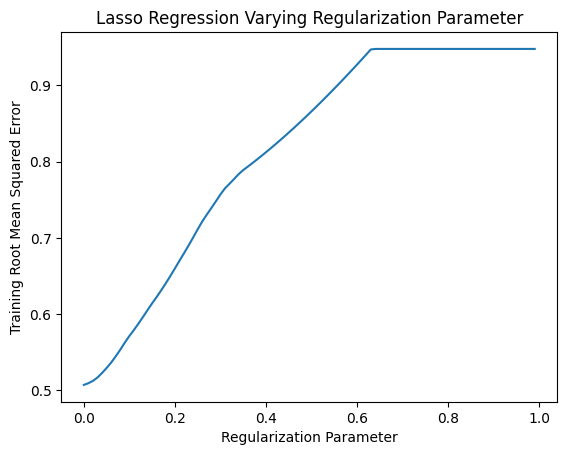

In [ ]:
# Lasso regression
alphas = np.arange(0.00, 1, 0.01)
out = alpha_search(Lasso, alphas)

plt.plot(alphas, out["training_rmses"])
plt.xlabel("Regularization Parameter")
plt.ylabel("Training Root Mean Squared Error")
plt.title("Lasso Regression Varying Regularization Parameter")
plt.show()